## Step1: Put all libraries and packages at top

### Standard imports

In [1]:
# files and system
import os
import sys

In [2]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [3]:
# working with images
import cv2
import imageio
import scipy.ndimage
import skimage.transform

import torchvision.transforms as transforms

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchsummary
from tqdm import notebook

### Custom imports

In [5]:
sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, iou_pytorch_test, IoULoss, IoUBCELoss

# dataset
from utils.dataset import myDataSet

sys.path.insert(0, './notebooks')

In [6]:
sys.path.insert(0, '../models')

# models
from unet import UNet

sys.path.insert(0, '../notebooks')

## Step 2: Fix a seed for reproducibility, and choose the DEVICE

In [7]:
random_seed=42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


## Step 3: Set your transforms, e.g, normalisation, resizing, rotation, flip, padding etc

In [9]:
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180), # allow any rotation
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

## Step 4: Make your train and validation data loader with option to augment or not

In [10]:
path_images = "../data/train-val/images"
path_masks = "../data/train-val/masks"


# pre-defined split
with open('../train-val-split/train.txt', 'r') as f:
    ids_train = [l.strip()+'.jpg' for l in f]
with open('../train-val-split/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]


custom_dataset_train = myDataSet(ids_train, path_images, path_masks, transforms=train_transforms)
custom_dataset_val = myDataSet(ids_val, path_images, path_masks, transforms=test_transforms)

print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))
print("My custom validation-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 880 elements
My custom validation-dataset has 120 elements


In [11]:
BATCH_SIZE = 20

# Create dataloaders from datasets with the native pytorch functions
dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

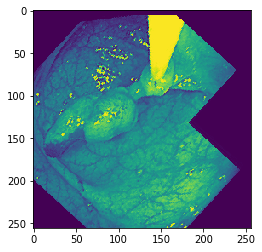

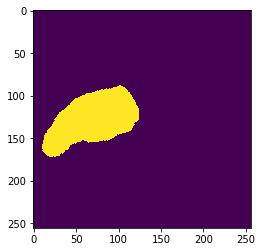

In [12]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)


# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()

In [13]:
custom_dataset_train.__getitem__(image_number)[0].shape

torch.Size([3, 256, 256])

In [14]:
custom_dataset_train.__getitem__(image_number)[1].shape, np.unique(custom_dataset_train.__getitem__(image_number)[1])

(torch.Size([1, 256, 256]), array([0., 1.], dtype=float32))

# Training hyperparameters

In [15]:
# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

In [16]:
# Define variables for the training
epochs = 100
patience=10

In [17]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCEWithLogitsLoss_augmented'

criterion = IoULoss()
model_name = 'UNet_IoULoss_augmented'

# criterion = IoUBCELoss()
# model_name = 'UNet_IoUBCELoss_augmented'


# Training

 Epoch: 0 of 100, Iter.: 44 of 44, Train Loss: -0.219956, IoU: 0.2918304
 Epoch: 0 of 100, Iter.: 44 of 44, Valid Loss: -0.231264, IoU: 0.269275


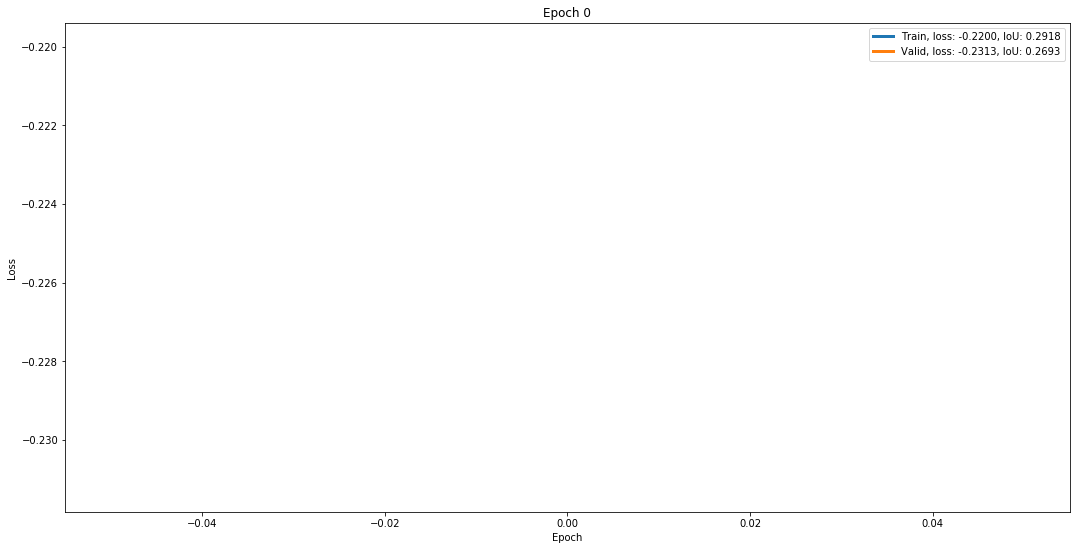

 Epoch: 1 of 100, Iter.: 44 of 44, Train Loss: -0.273373, IoU: 0.3585179
 Epoch: 1 of 100, Iter.: 44 of 44, Valid Loss: -0.260659, IoU: 0.330514


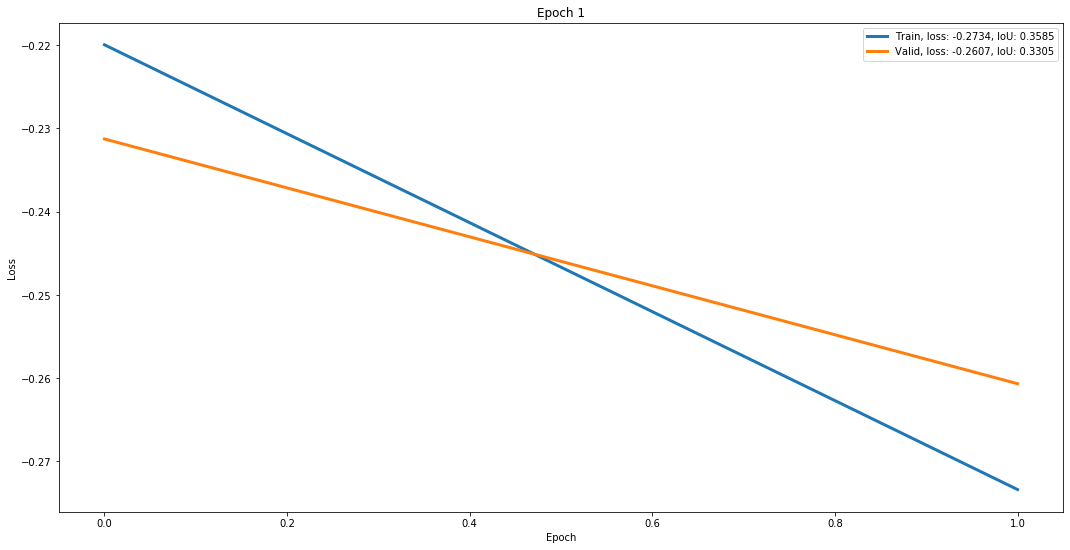

 Epoch: 2 of 100, Iter.: 44 of 44, Train Loss: -0.296347, IoU: 0.3816461
 Epoch: 2 of 100, Iter.: 44 of 44, Valid Loss: -0.276531, IoU: 0.323366


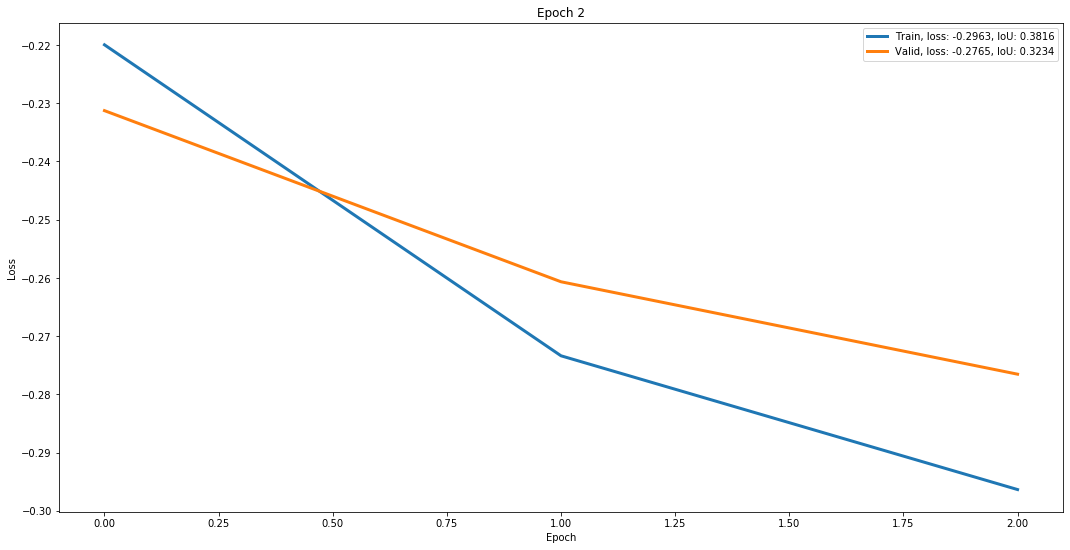

 Epoch: 3 of 100, Iter.: 44 of 44, Train Loss: -0.315471, IoU: 0.3956440
 Epoch: 3 of 100, Iter.: 44 of 44, Valid Loss: -0.287220, IoU: 0.328989


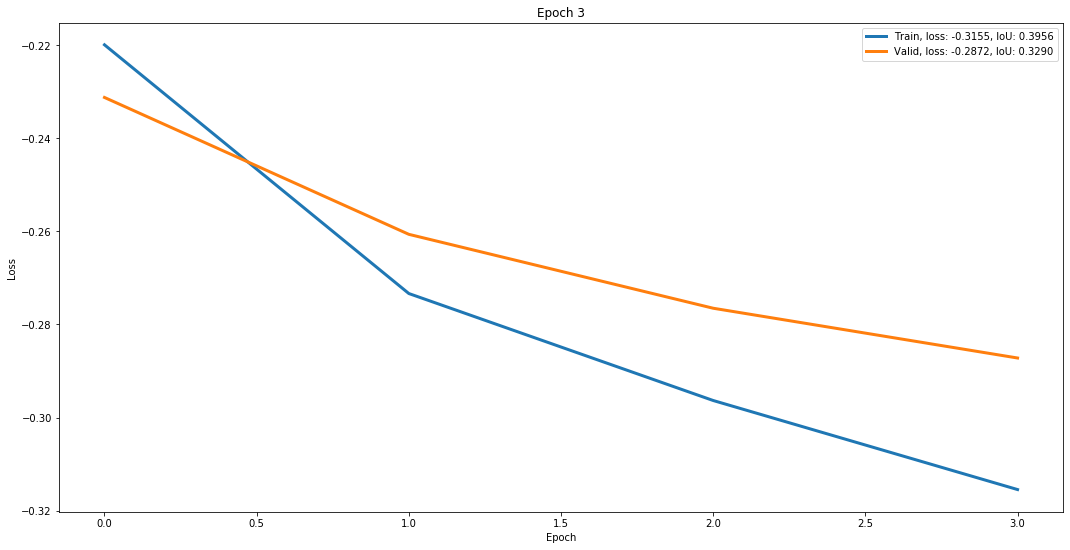

 Epoch: 4 of 100, Iter.: 44 of 44, Train Loss: -0.334049, IoU: 0.4120712
 Epoch: 4 of 100, Iter.: 44 of 44, Valid Loss: -0.304282, IoU: 0.345749


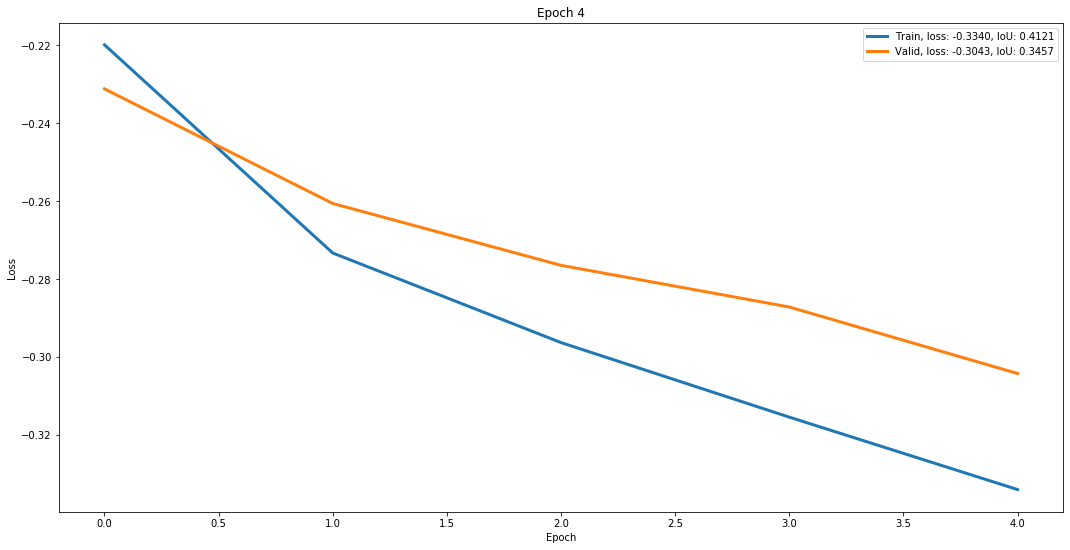

 Epoch: 5 of 100, Iter.: 44 of 44, Train Loss: -0.351181, IoU: 0.4232670
 Epoch: 5 of 100, Iter.: 44 of 44, Valid Loss: -0.309100, IoU: 0.350595


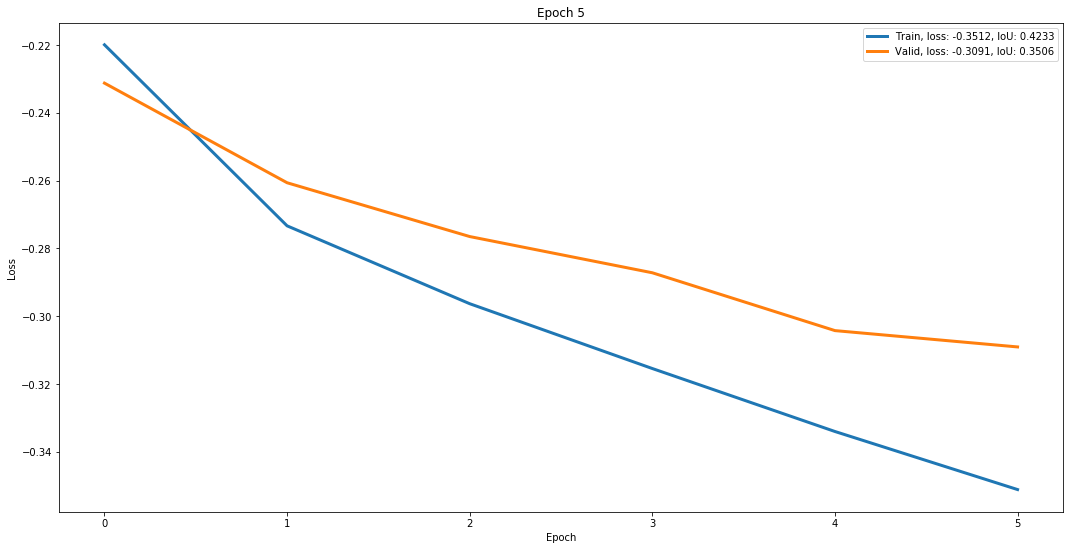

 Epoch: 6 of 100, Iter.: 44 of 44, Train Loss: -0.364763, IoU: 0.4358555
 Epoch: 6 of 100, Iter.: 44 of 44, Valid Loss: -0.325325, IoU: 0.375866


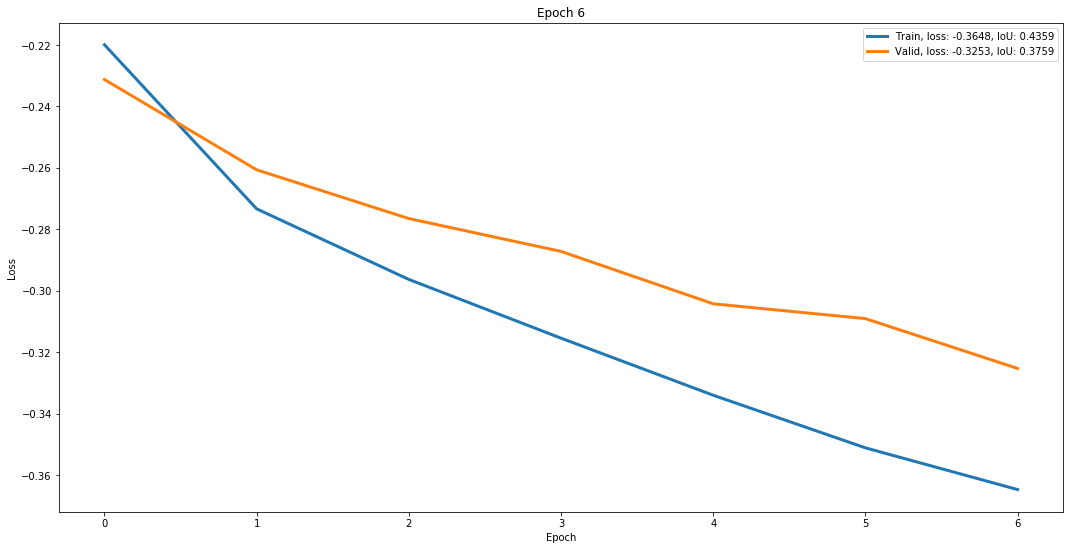

 Epoch: 7 of 100, Iter.: 44 of 44, Train Loss: -0.381655, IoU: 0.4569216
 Epoch: 7 of 100, Iter.: 44 of 44, Valid Loss: -0.325696, IoU: 0.359641


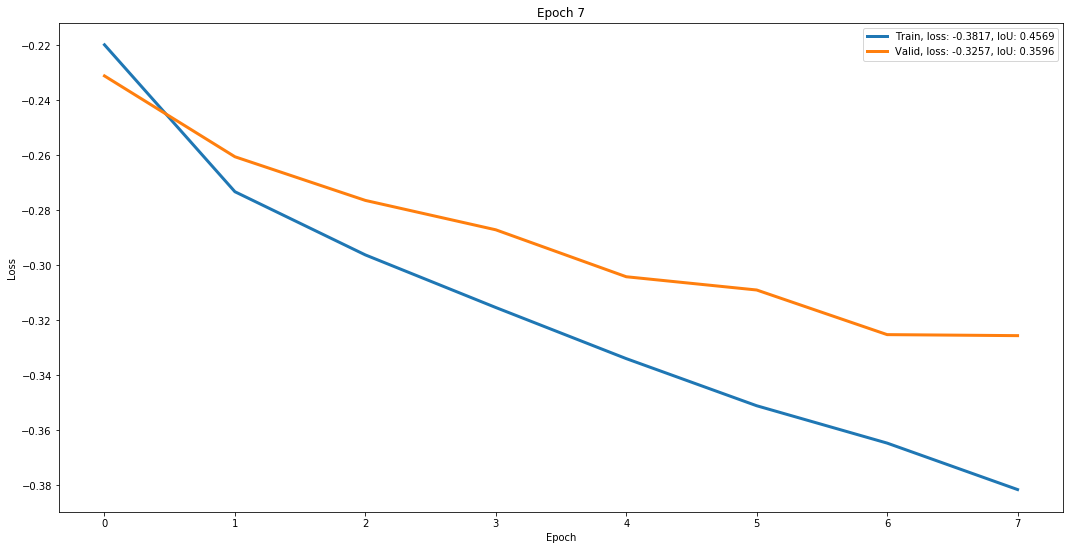

 Epoch: 8 of 100, Iter.: 44 of 44, Train Loss: -0.396463, IoU: 0.4662710
 Epoch: 8 of 100, Iter.: 44 of 44, Valid Loss: -0.376770, IoU: 0.428354


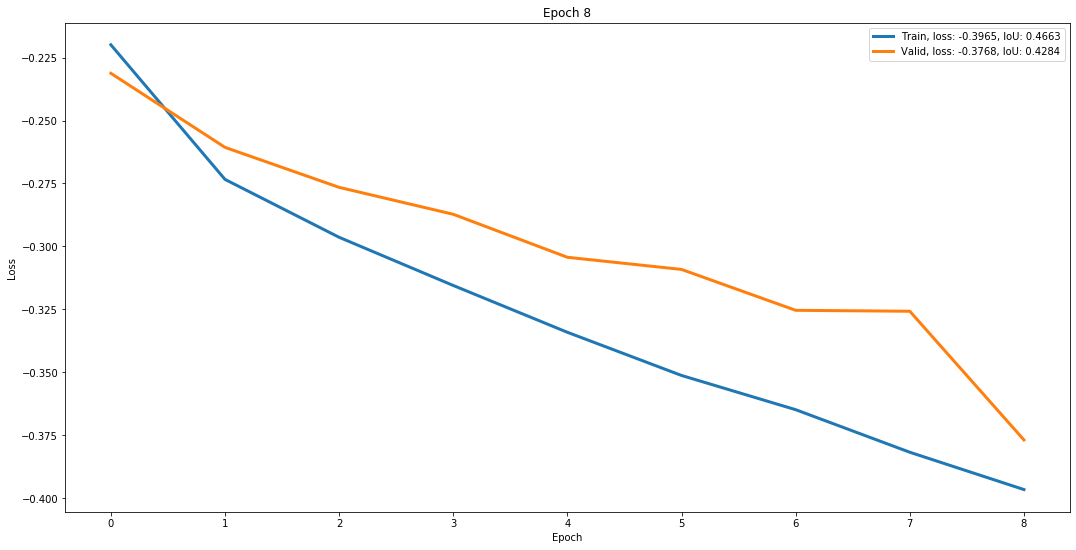

 Epoch: 9 of 100, Iter.: 44 of 44, Train Loss: -0.422247, IoU: 0.5026146
 Epoch: 9 of 100, Iter.: 44 of 44, Valid Loss: -0.369756, IoU: 0.451830


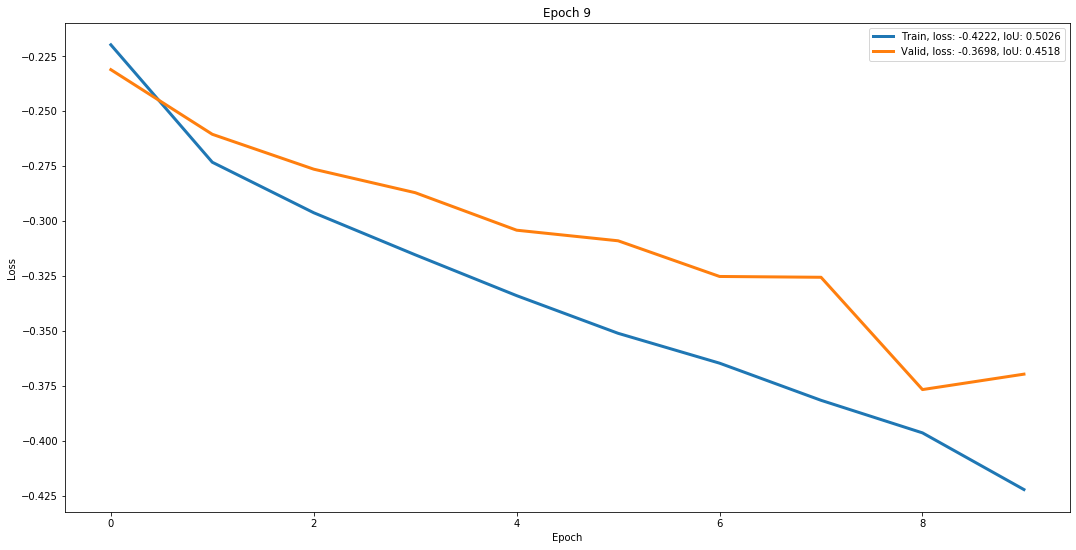

 Epoch: 10 of 100, Iter.: 44 of 44, Train Loss: -0.432517, IoU: 0.5076033
 Epoch: 10 of 100, Iter.: 44 of 44, Valid Loss: -0.395653, IoU: 0.448296


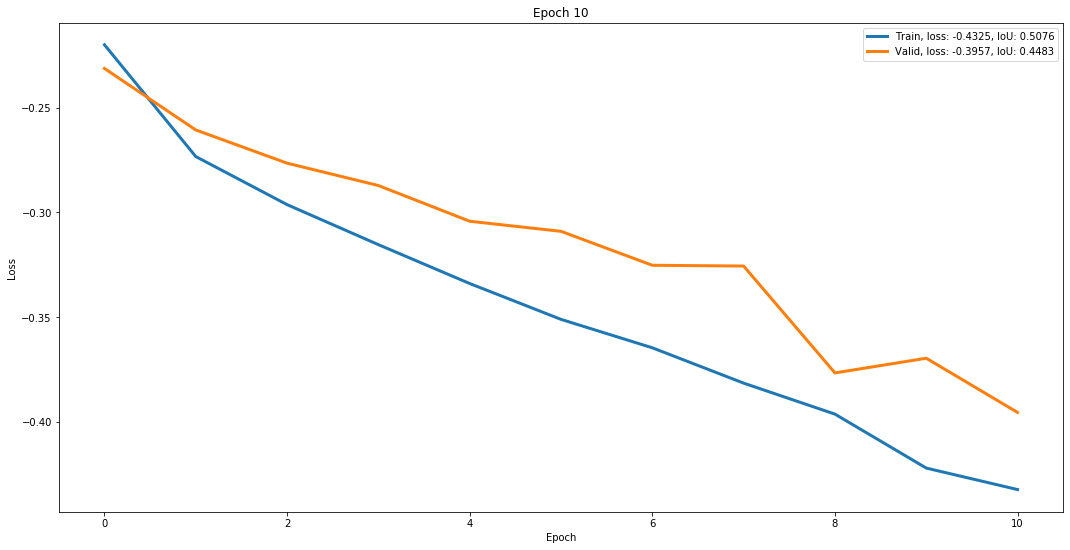

 Epoch: 11 of 100, Iter.: 44 of 44, Train Loss: -0.460247, IoU: 0.5443673
 Epoch: 11 of 100, Iter.: 44 of 44, Valid Loss: -0.400033, IoU: 0.455554


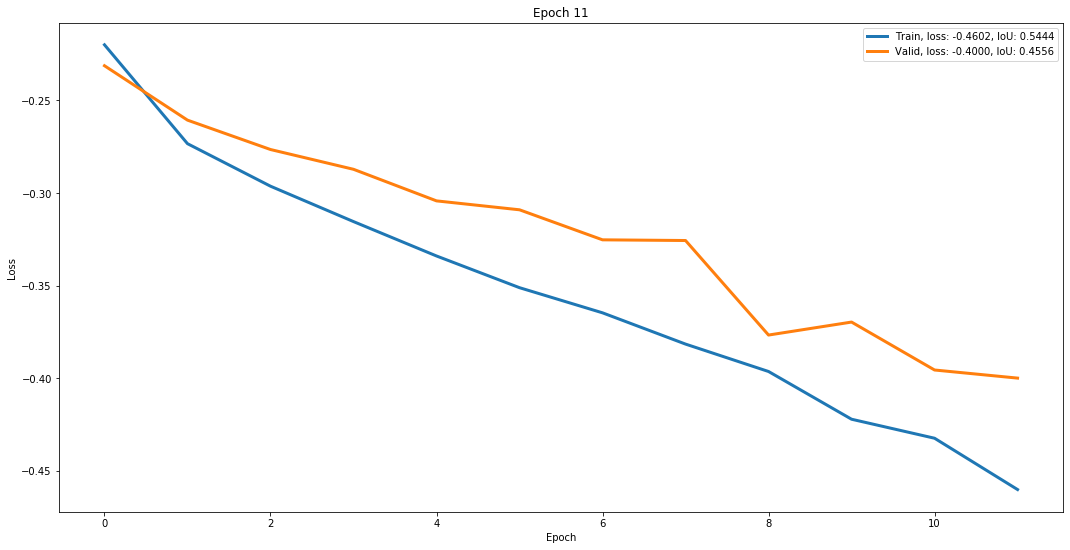

 Epoch: 12 of 100, Iter.: 44 of 44, Train Loss: -0.474998, IoU: 0.5581840
 Epoch: 12 of 100, Iter.: 44 of 44, Valid Loss: -0.448620, IoU: 0.528491


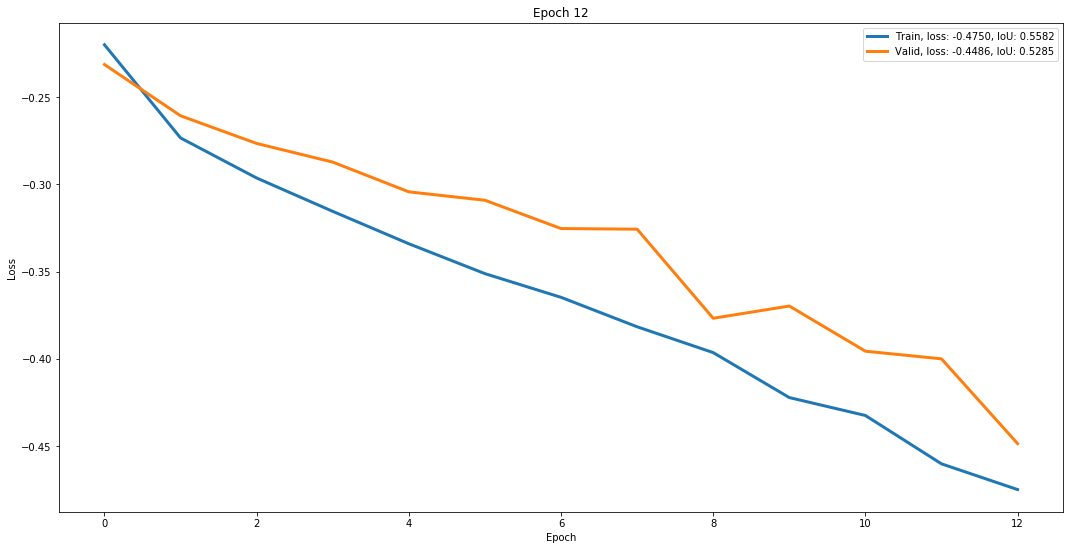

 Epoch: 13 of 100, Iter.: 44 of 44, Train Loss: -0.494081, IoU: 0.5770490
 Epoch: 13 of 100, Iter.: 44 of 44, Valid Loss: -0.432520, IoU: 0.488090


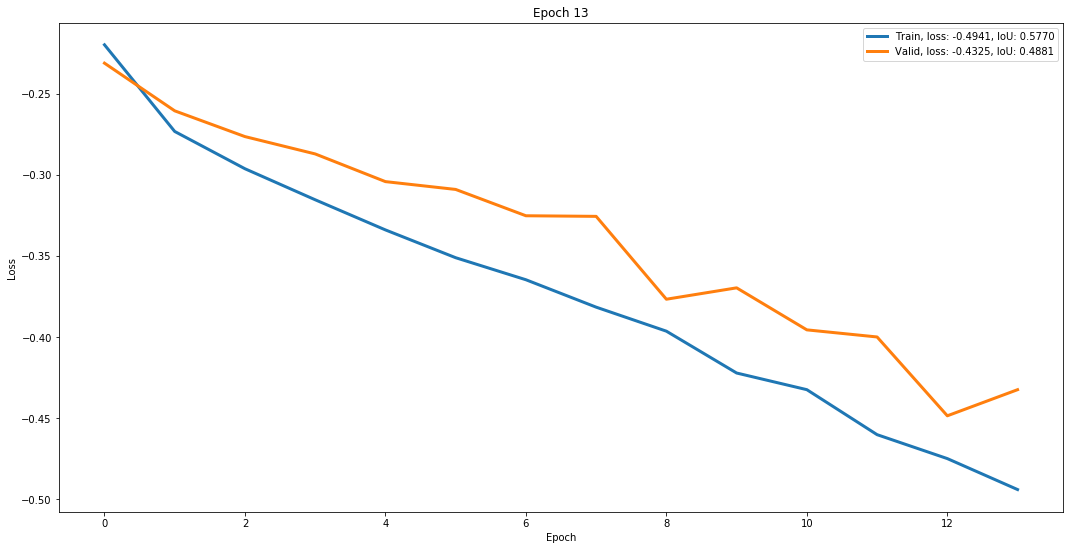

 Epoch: 14 of 100, Iter.: 44 of 44, Train Loss: -0.512353, IoU: 0.5939641
 Epoch: 14 of 100, Iter.: 44 of 44, Valid Loss: -0.459861, IoU: 0.532258


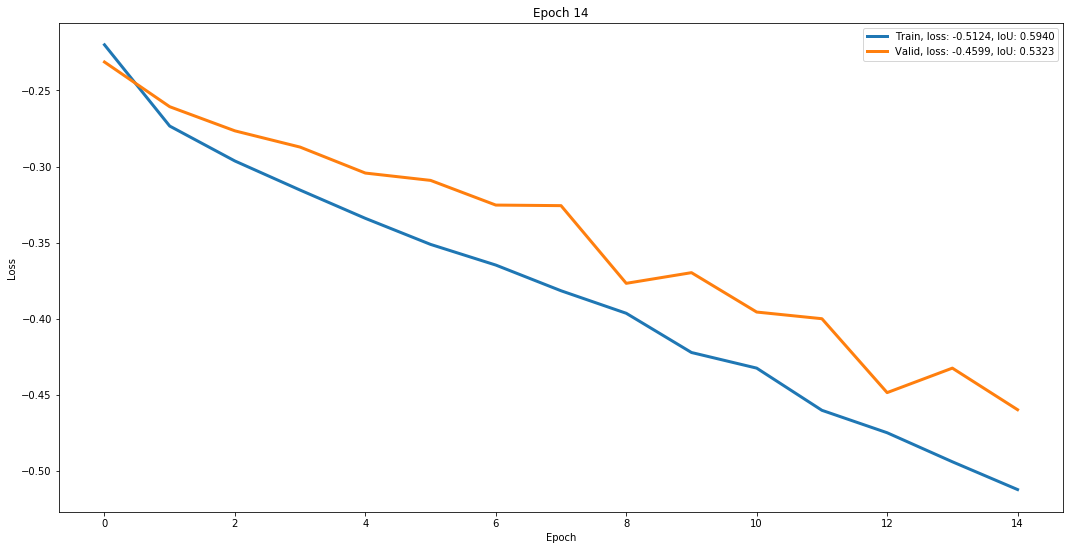

 Epoch: 15 of 100, Iter.: 44 of 44, Train Loss: -0.529563, IoU: 0.5993259
 Epoch: 15 of 100, Iter.: 44 of 44, Valid Loss: -0.462339, IoU: 0.521720


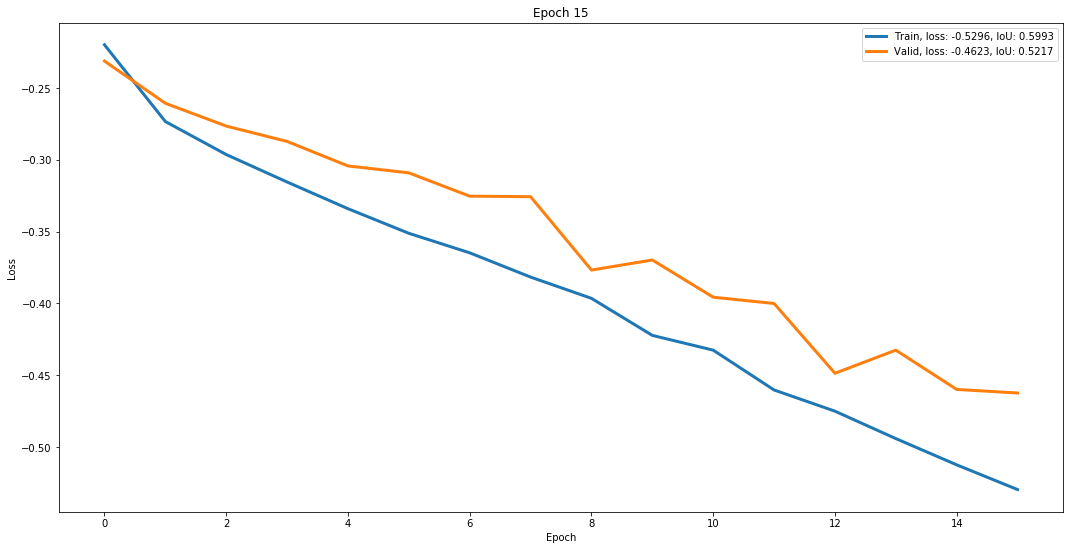

 Epoch: 16 of 100, Iter.: 44 of 44, Train Loss: -0.541314, IoU: 0.6158870
 Epoch: 16 of 100, Iter.: 44 of 44, Valid Loss: -0.473130, IoU: 0.532257


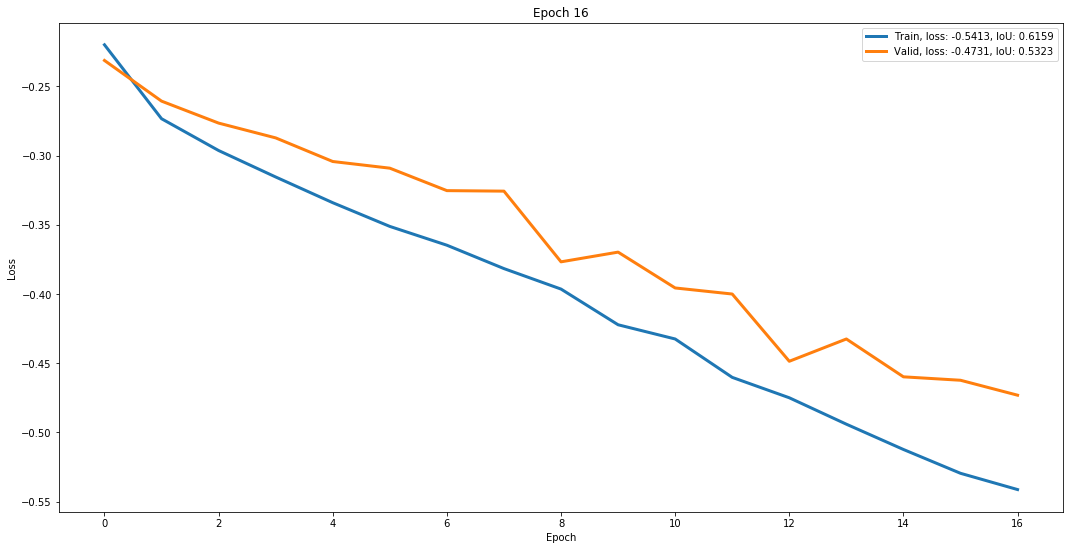

 Epoch: 17 of 100, Iter.: 44 of 44, Train Loss: -0.570197, IoU: 0.6407236
 Epoch: 17 of 100, Iter.: 44 of 44, Valid Loss: -0.519496, IoU: 0.585650


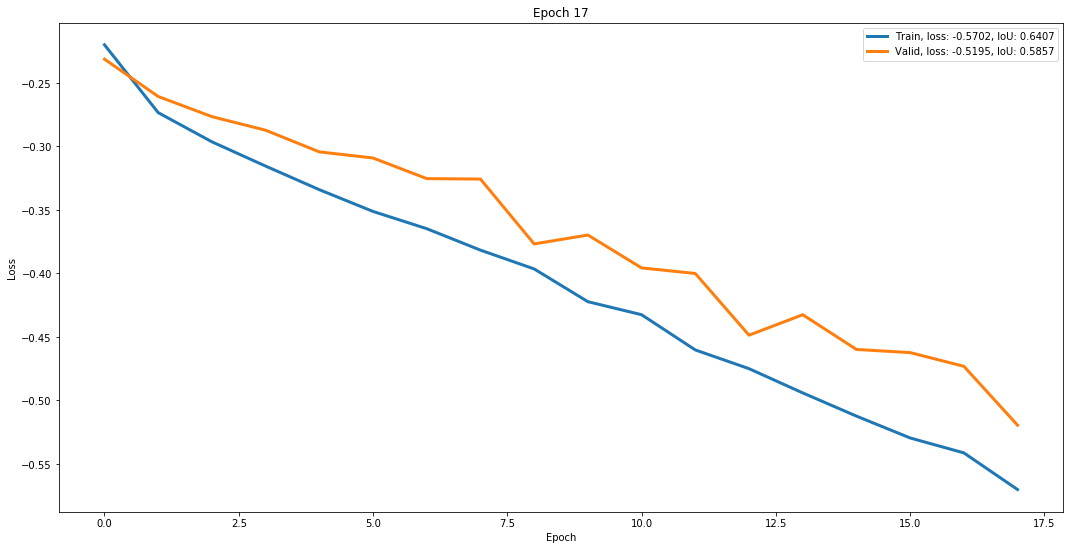

 Epoch: 18 of 100, Iter.: 44 of 44, Train Loss: -0.567616, IoU: 0.6330471
 Epoch: 18 of 100, Iter.: 44 of 44, Valid Loss: -0.516111, IoU: 0.560892


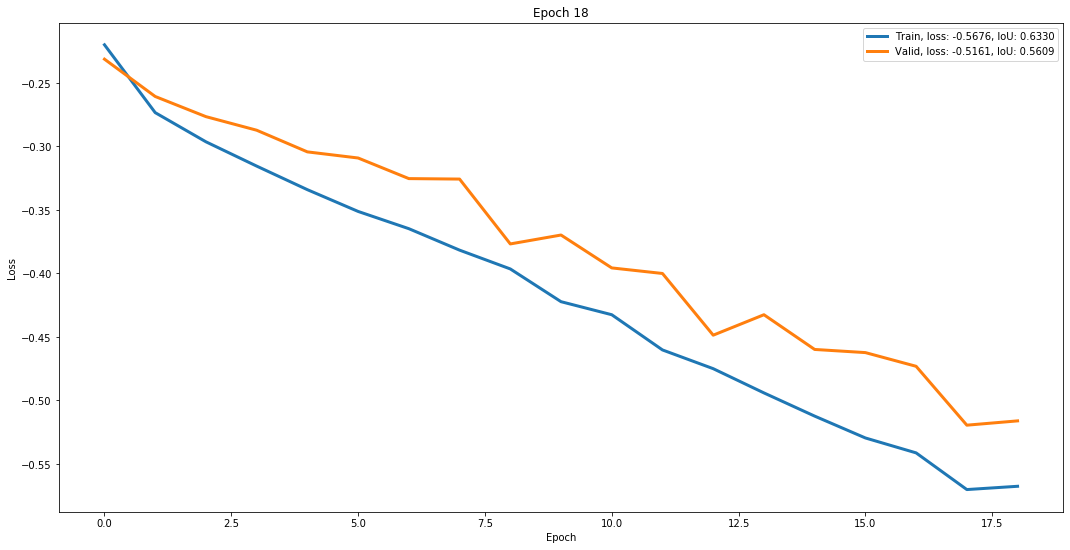

 Epoch: 19 of 100, Iter.: 44 of 44, Train Loss: -0.582803, IoU: 0.6380935
 Epoch: 19 of 100, Iter.: 44 of 44, Valid Loss: -0.480485, IoU: 0.519528


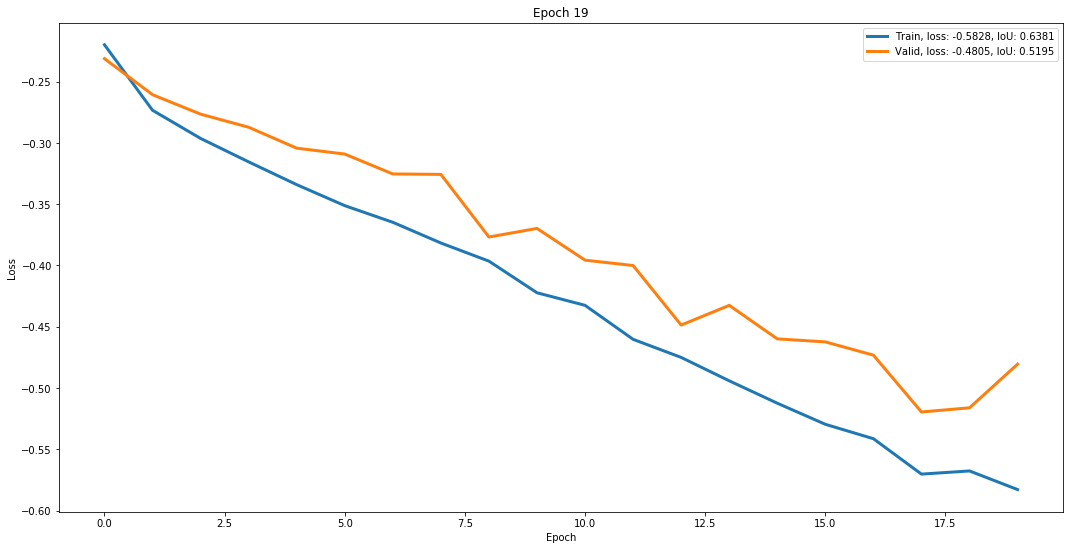

 Epoch: 20 of 100, Iter.: 44 of 44, Train Loss: -0.598358, IoU: 0.6473163
 Epoch: 20 of 100, Iter.: 44 of 44, Valid Loss: -0.472403, IoU: 0.517526


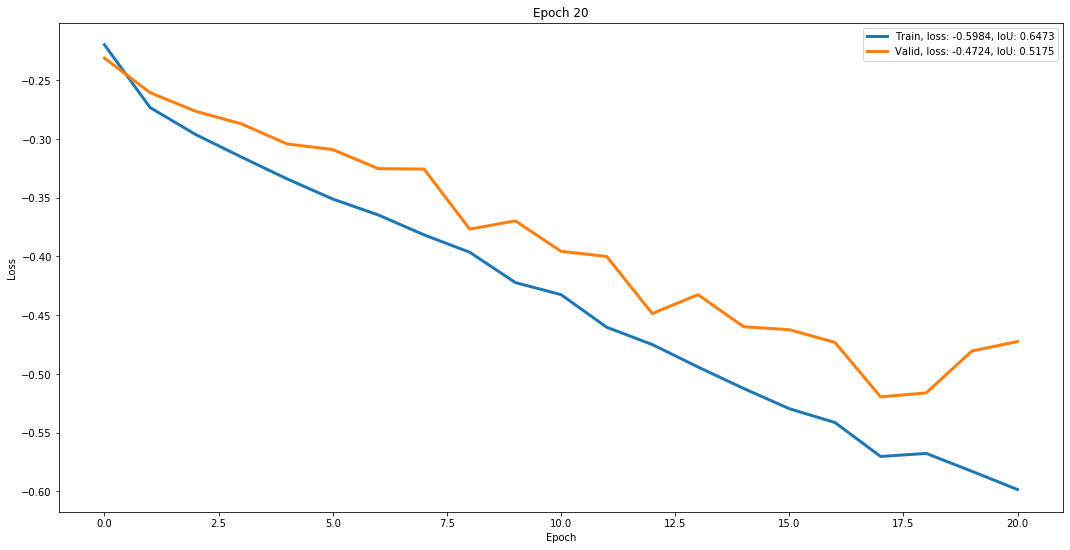

 Epoch: 21 of 100, Iter.: 44 of 44, Train Loss: -0.607854, IoU: 0.6595297
 Epoch: 21 of 100, Iter.: 44 of 44, Valid Loss: -0.558687, IoU: 0.623066


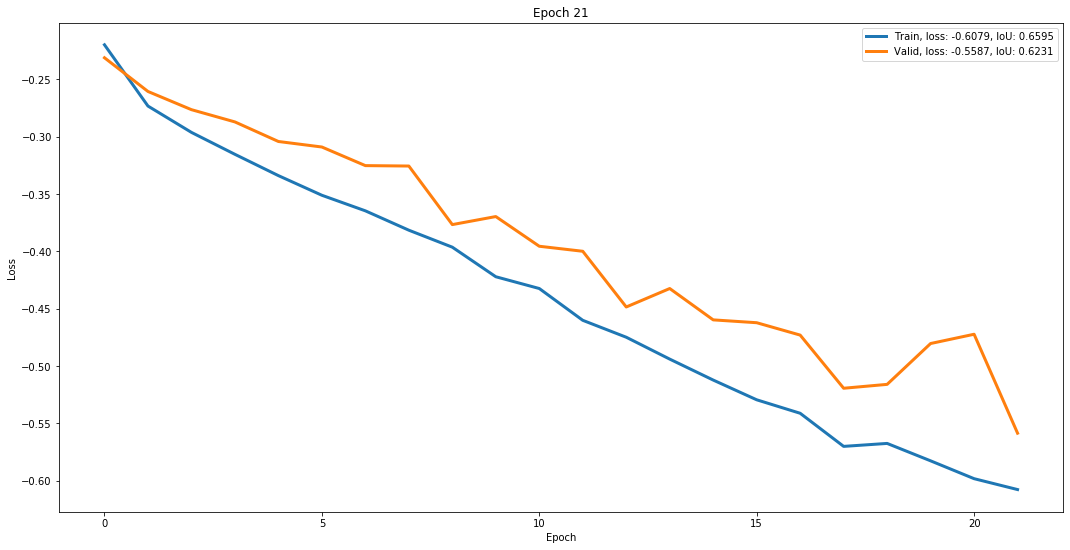

 Epoch: 22 of 100, Iter.: 44 of 44, Train Loss: -0.608412, IoU: 0.6574862
 Epoch: 22 of 100, Iter.: 44 of 44, Valid Loss: -0.560922, IoU: 0.604997


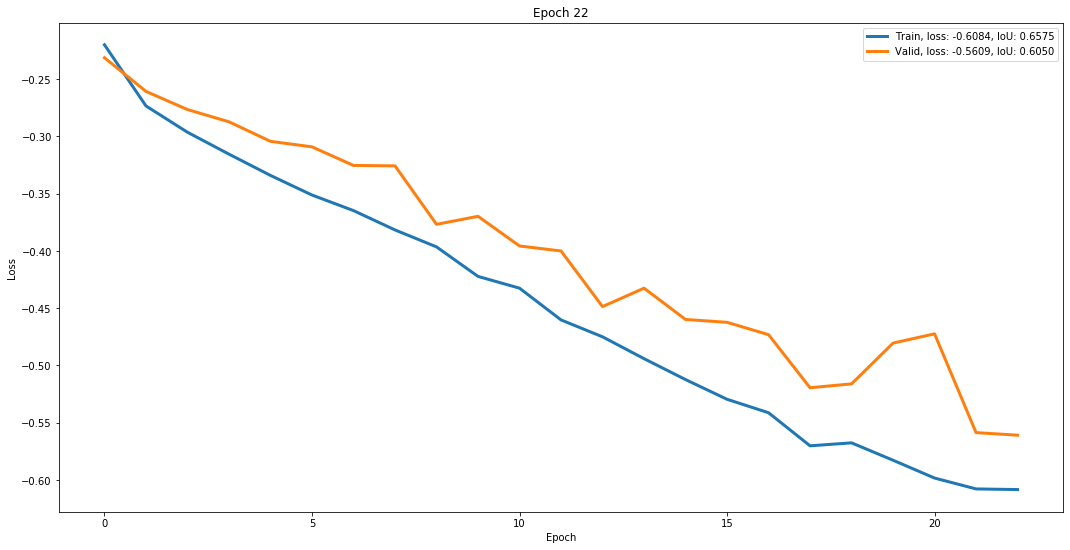

 Epoch: 23 of 100, Iter.: 44 of 44, Train Loss: -0.619179, IoU: 0.6630711
 Epoch: 23 of 100, Iter.: 44 of 44, Valid Loss: -0.562251, IoU: 0.607454


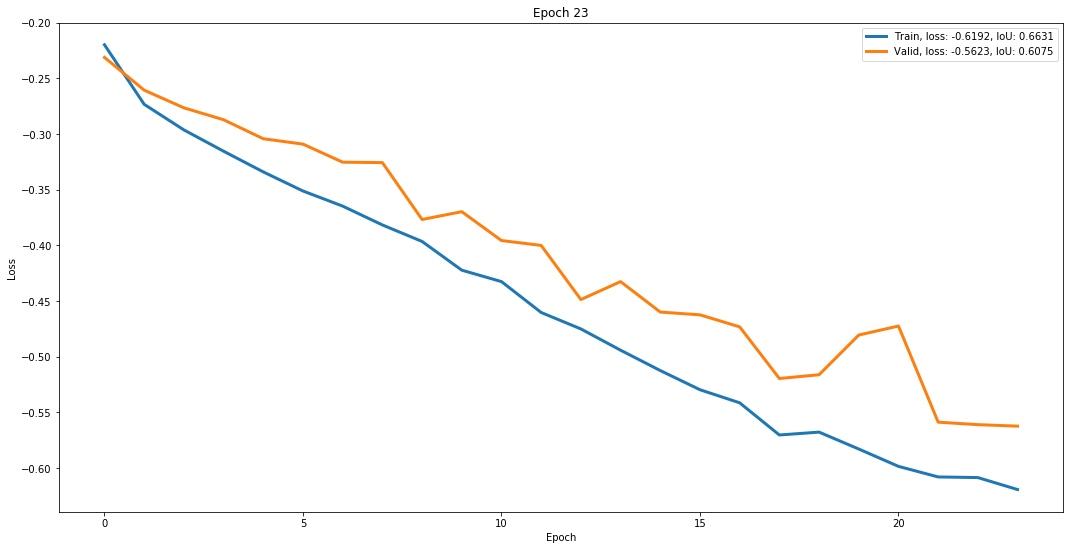

 Epoch: 24 of 100, Iter.: 44 of 44, Train Loss: -0.625518, IoU: 0.6644440
 Epoch: 24 of 100, Iter.: 44 of 44, Valid Loss: -0.489740, IoU: 0.525264


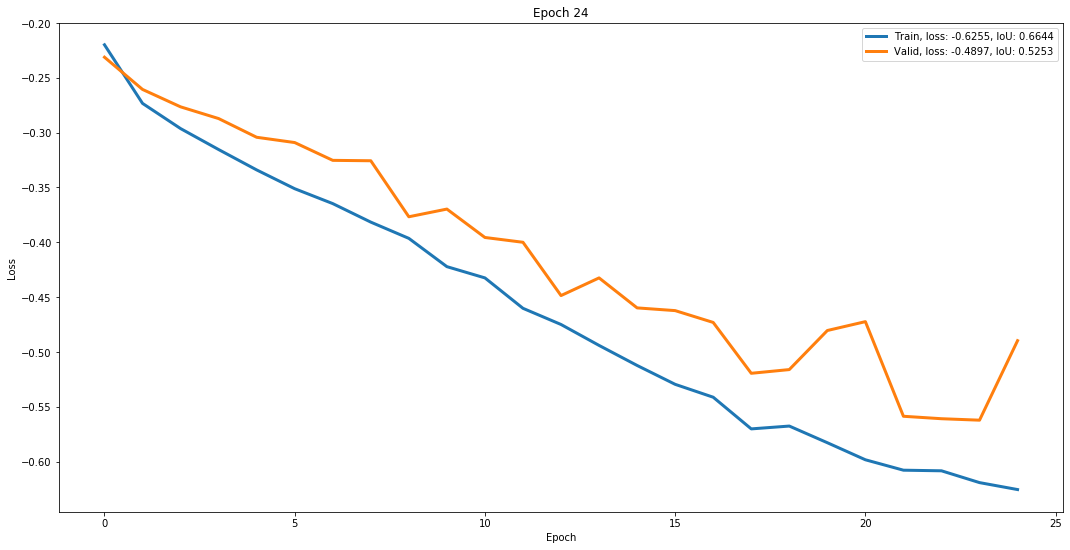

 Epoch: 25 of 100, Iter.: 44 of 44, Train Loss: -0.637994, IoU: 0.6774626
 Epoch: 25 of 100, Iter.: 44 of 44, Valid Loss: -0.548556, IoU: 0.588339


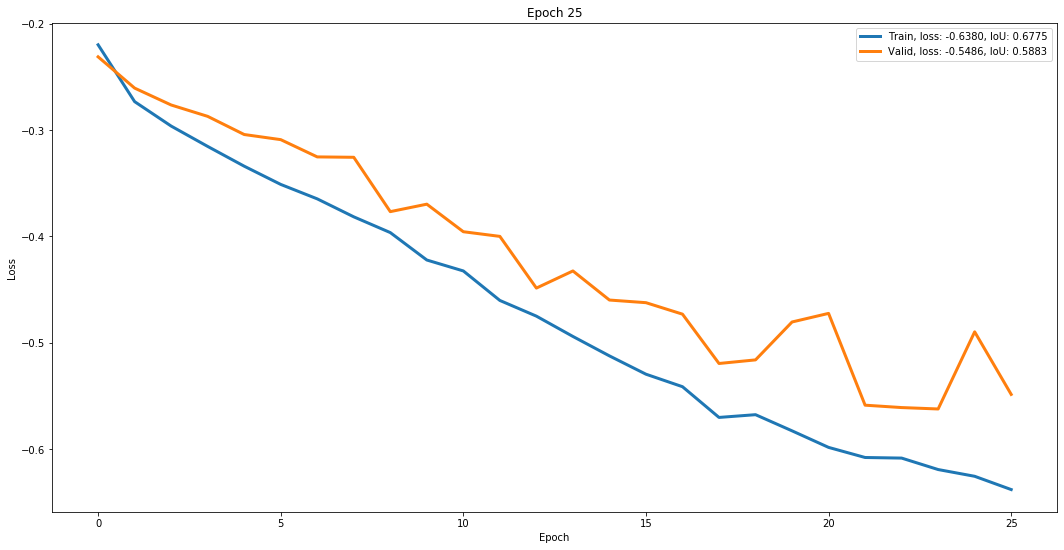

 Epoch: 26 of 100, Iter.: 44 of 44, Train Loss: -0.643582, IoU: 0.6827976
 Epoch: 26 of 100, Iter.: 44 of 44, Valid Loss: -0.567426, IoU: 0.604463


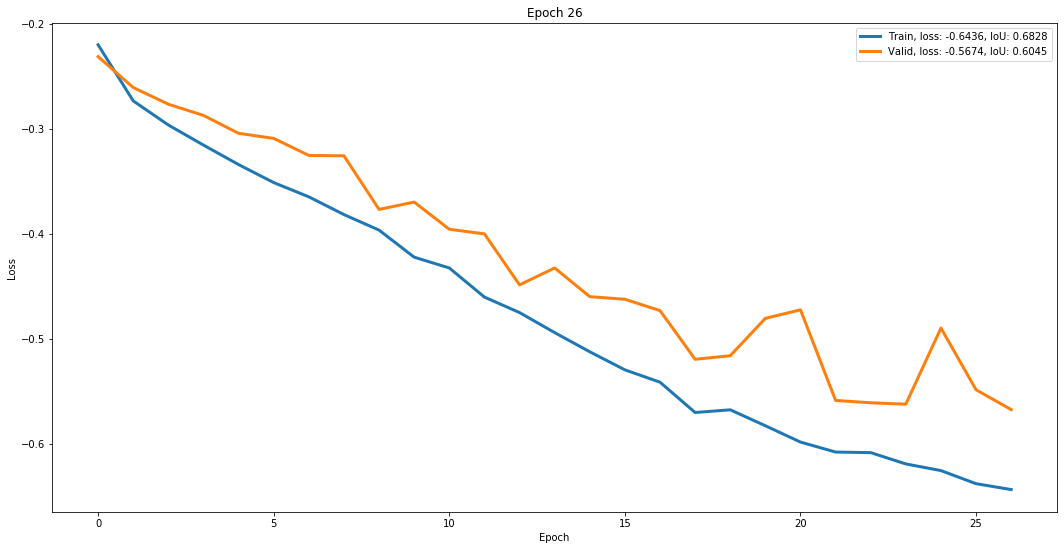

 Epoch: 27 of 100, Iter.: 44 of 44, Train Loss: -0.645919, IoU: 0.6803041
 Epoch: 27 of 100, Iter.: 44 of 44, Valid Loss: -0.532761, IoU: 0.541984


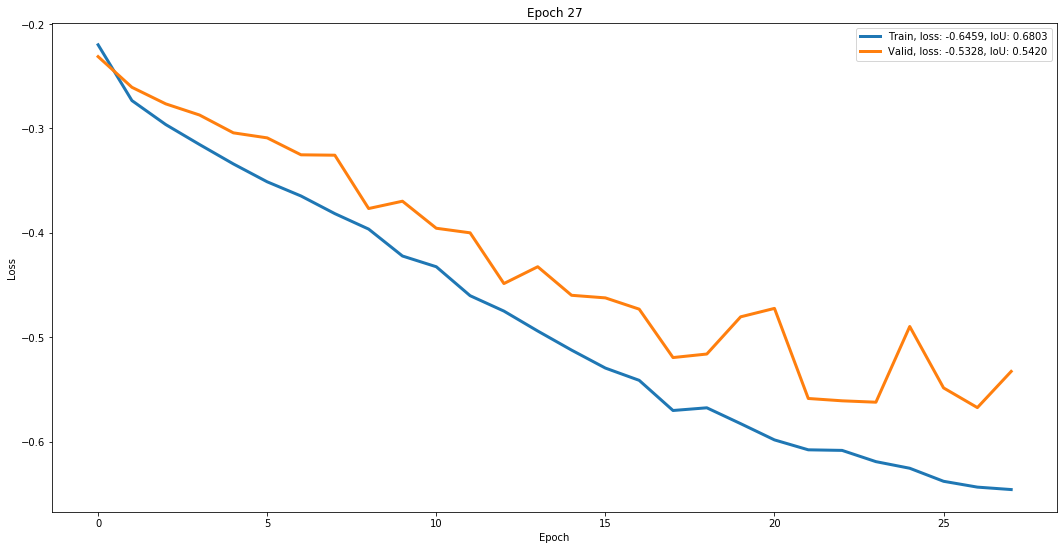

 Epoch: 28 of 100, Iter.: 44 of 44, Train Loss: -0.648402, IoU: 0.6788556
 Epoch: 28 of 100, Iter.: 44 of 44, Valid Loss: -0.568116, IoU: 0.592343


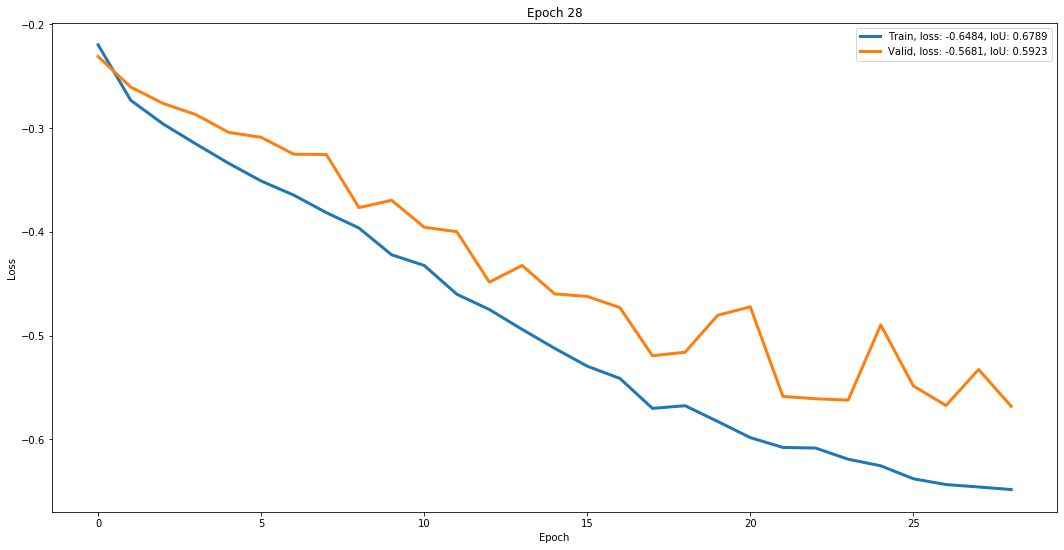

 Epoch: 29 of 100, Iter.: 44 of 44, Train Loss: -0.651318, IoU: 0.6837570
 Epoch: 29 of 100, Iter.: 44 of 44, Valid Loss: -0.519330, IoU: 0.550488


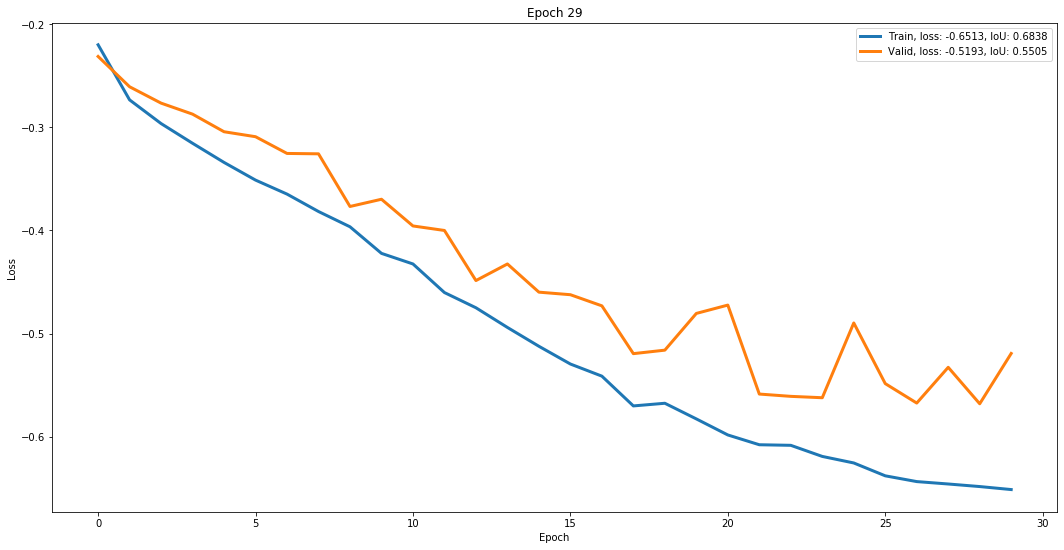

 Epoch: 30 of 100, Iter.: 44 of 44, Train Loss: -0.663750, IoU: 0.6961497
 Epoch: 30 of 100, Iter.: 44 of 44, Valid Loss: -0.581757, IoU: 0.624165


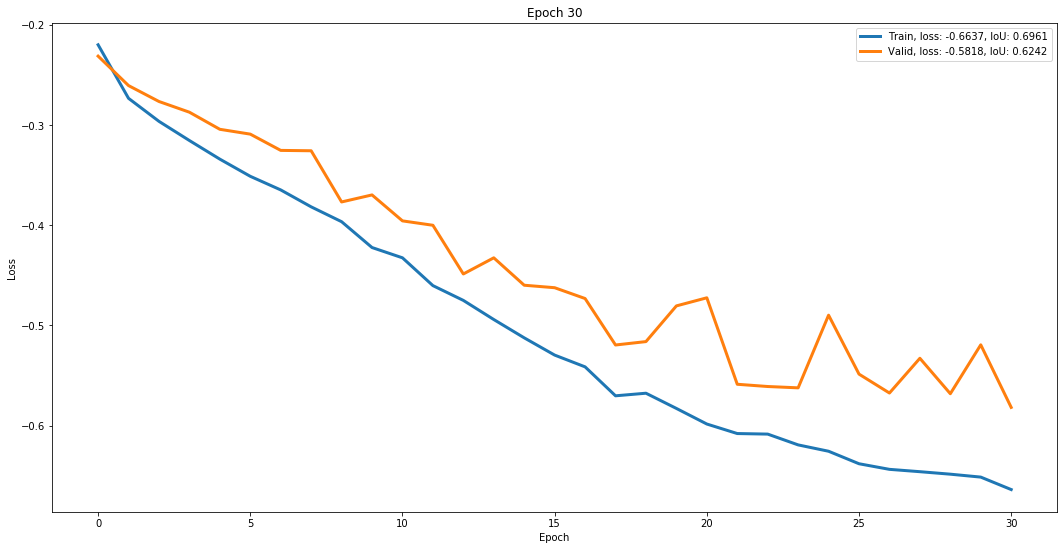

 Epoch: 31 of 100, Iter.: 44 of 44, Train Loss: -0.672593, IoU: 0.7056634
 Epoch: 31 of 100, Iter.: 44 of 44, Valid Loss: -0.596354, IoU: 0.629095


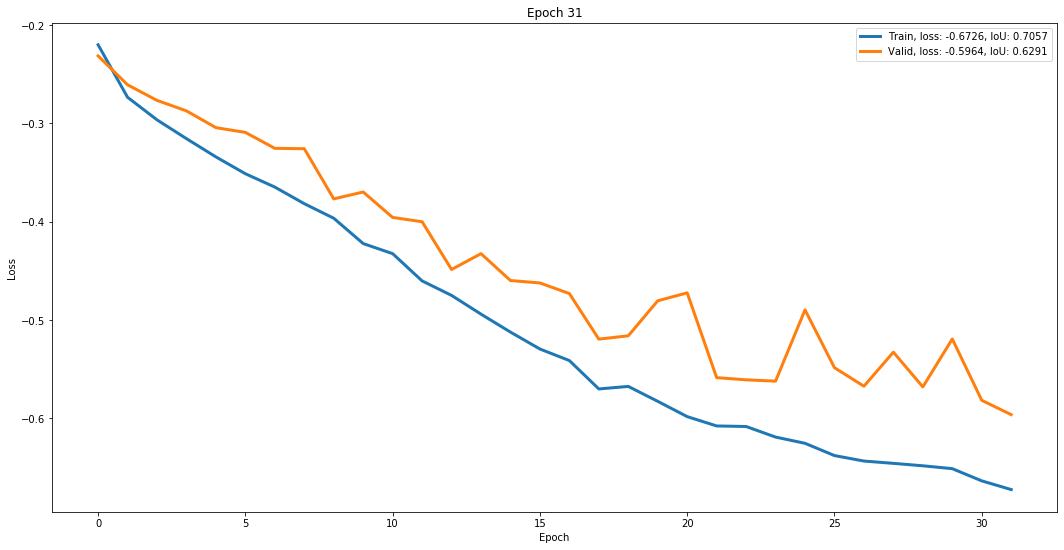

 Epoch: 32 of 100, Iter.: 44 of 44, Train Loss: -0.677276, IoU: 0.7068213
 Epoch: 32 of 100, Iter.: 44 of 44, Valid Loss: -0.594643, IoU: 0.625500


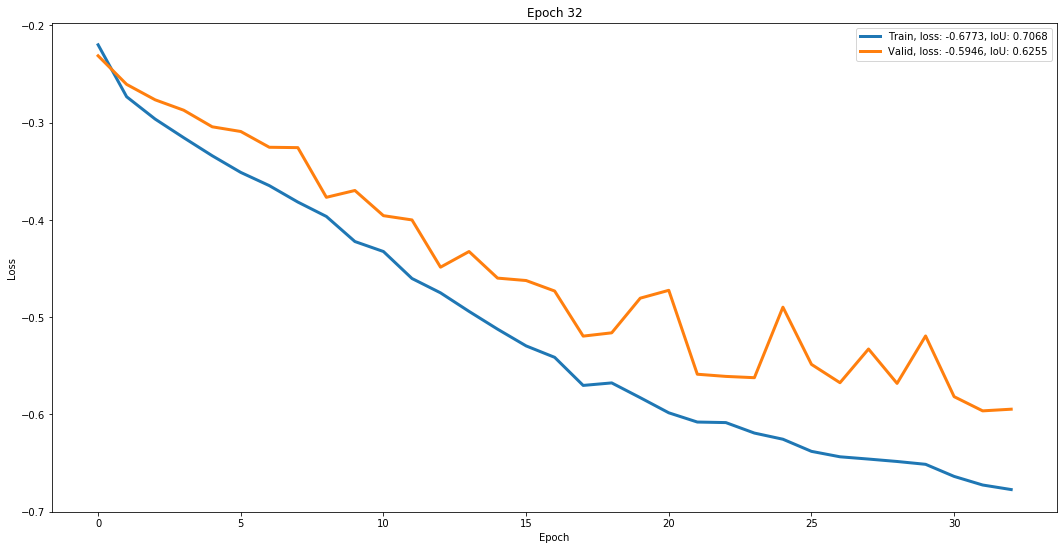

 Epoch: 33 of 100, Iter.: 44 of 44, Train Loss: -0.679918, IoU: 0.7041094
 Epoch: 33 of 100, Iter.: 44 of 44, Valid Loss: -0.598904, IoU: 0.626255


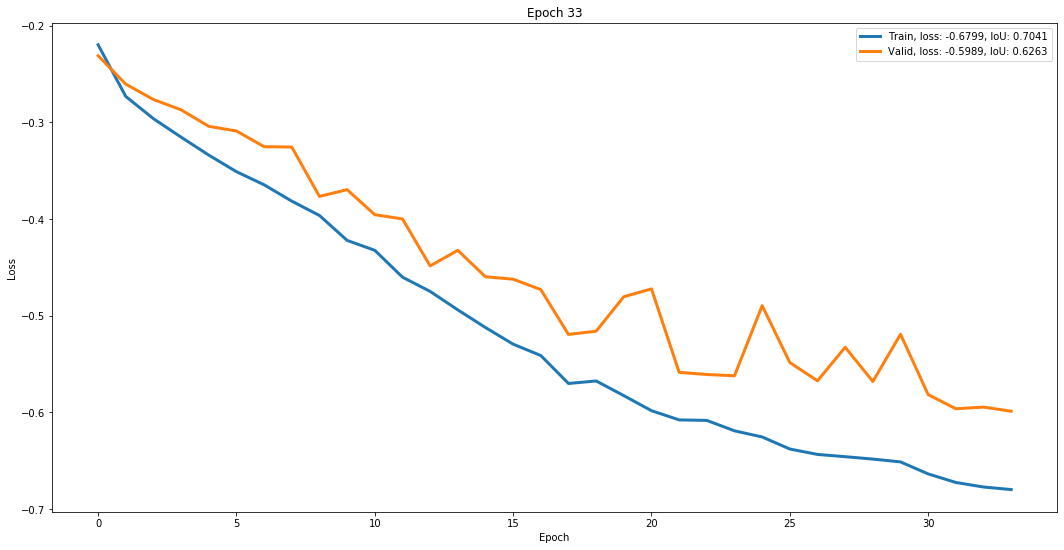

 Epoch: 34 of 100, Iter.: 44 of 44, Train Loss: -0.684475, IoU: 0.7077650
 Epoch: 34 of 100, Iter.: 44 of 44, Valid Loss: -0.592780, IoU: 0.609072


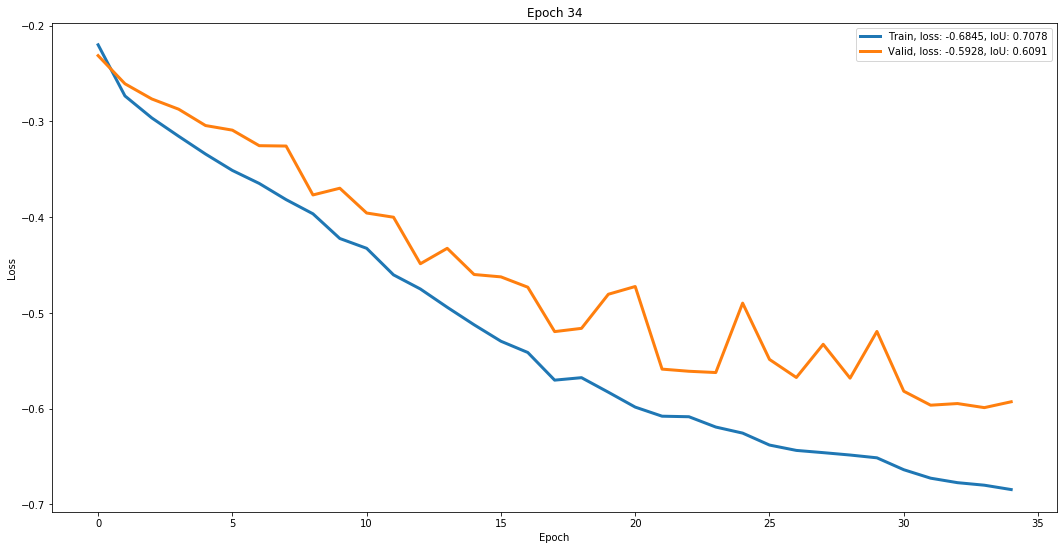

 Epoch: 35 of 100, Iter.: 44 of 44, Train Loss: -0.685990, IoU: 0.7083808
 Epoch: 35 of 100, Iter.: 44 of 44, Valid Loss: -0.581648, IoU: 0.600881


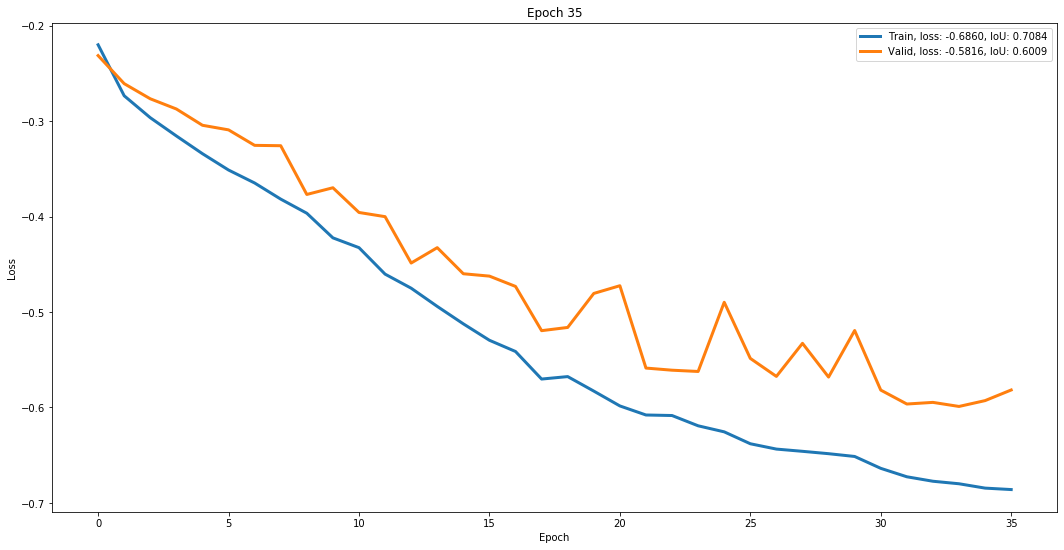

 Epoch: 36 of 100, Iter.: 44 of 44, Train Loss: -0.681025, IoU: 0.7055517
 Epoch: 36 of 100, Iter.: 44 of 44, Valid Loss: -0.637417, IoU: 0.661291


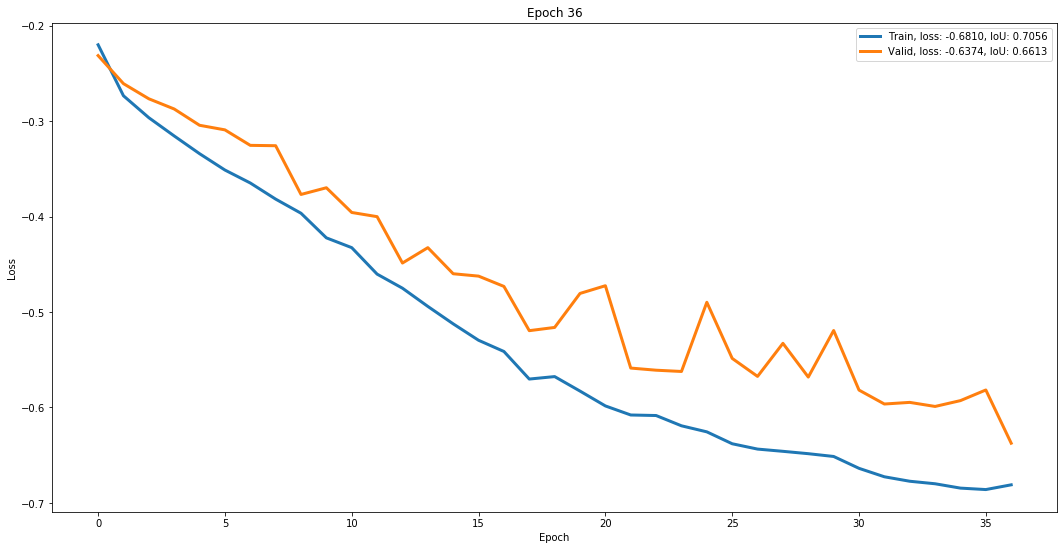

 Epoch: 37 of 100, Iter.: 44 of 44, Train Loss: -0.702450, IoU: 0.7254019
 Epoch: 37 of 100, Iter.: 44 of 44, Valid Loss: -0.646989, IoU: 0.666430


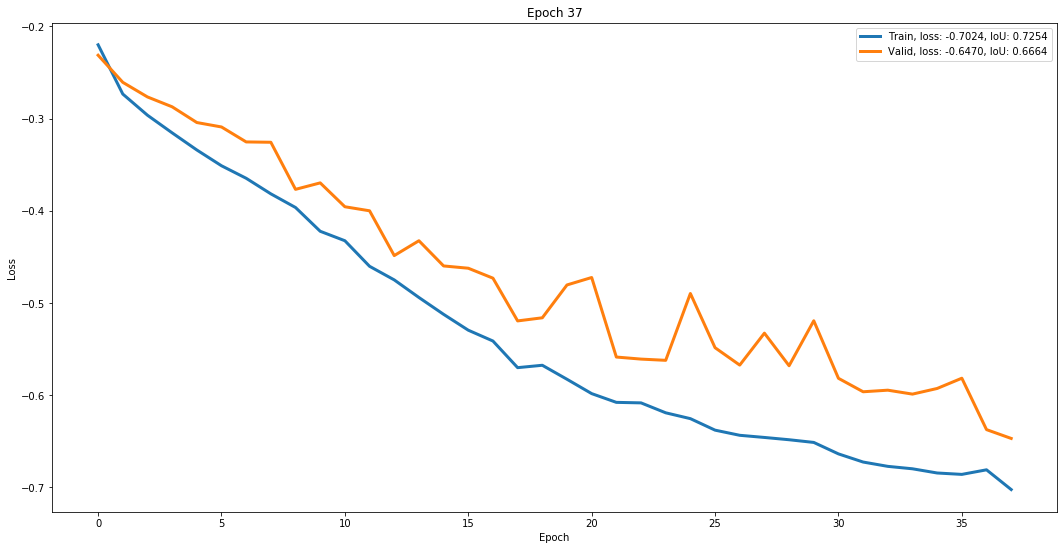

 Epoch: 38 of 100, Iter.: 44 of 44, Train Loss: -0.700790, IoU: 0.7230253
 Epoch: 38 of 100, Iter.: 44 of 44, Valid Loss: -0.511603, IoU: 0.549982


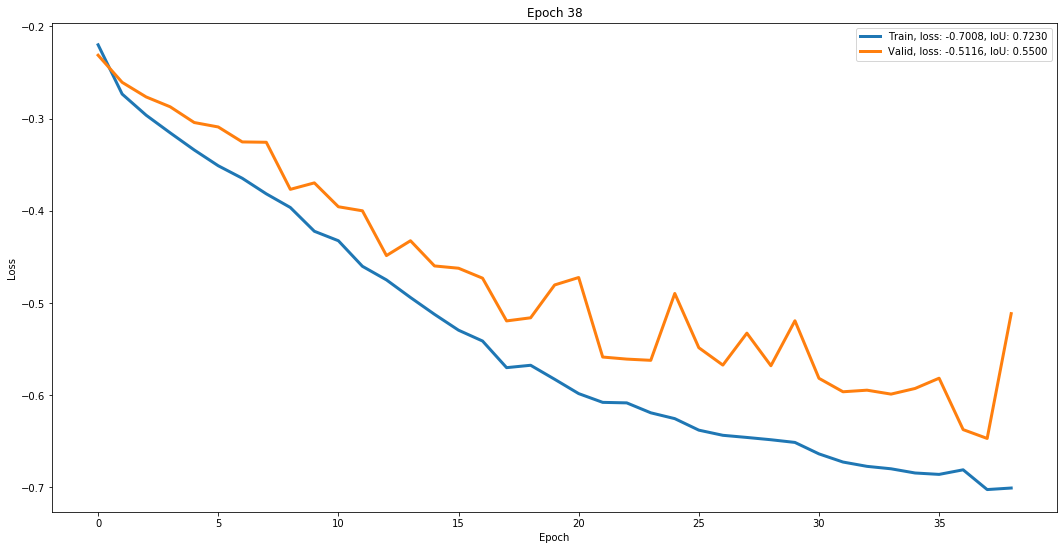

 Epoch: 39 of 100, Iter.: 44 of 44, Train Loss: -0.703226, IoU: 0.7250269
 Epoch: 39 of 100, Iter.: 44 of 44, Valid Loss: -0.558259, IoU: 0.585430


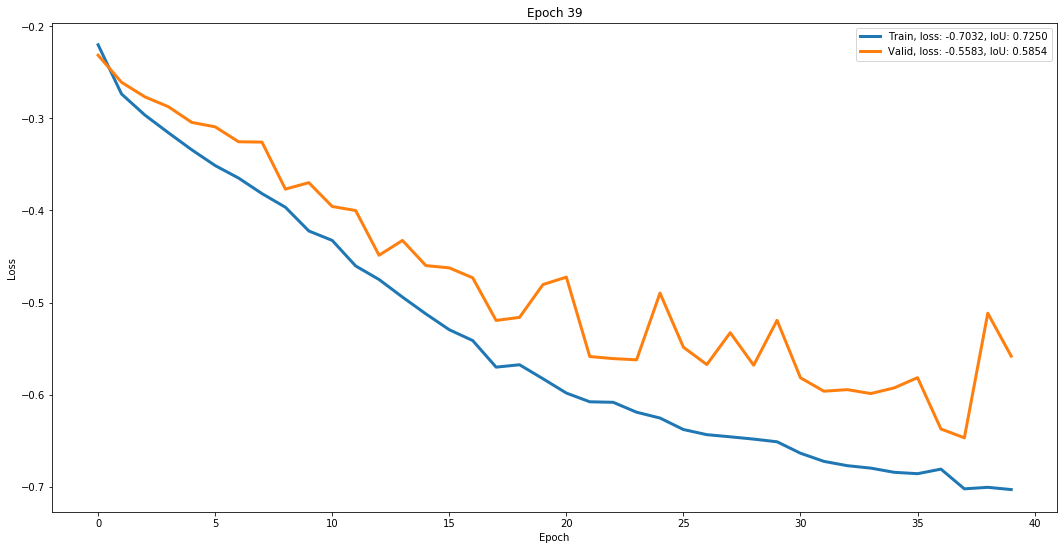

 Epoch: 40 of 100, Iter.: 44 of 44, Train Loss: -0.698003, IoU: 0.7207800
 Epoch: 40 of 100, Iter.: 44 of 44, Valid Loss: -0.639630, IoU: 0.664807


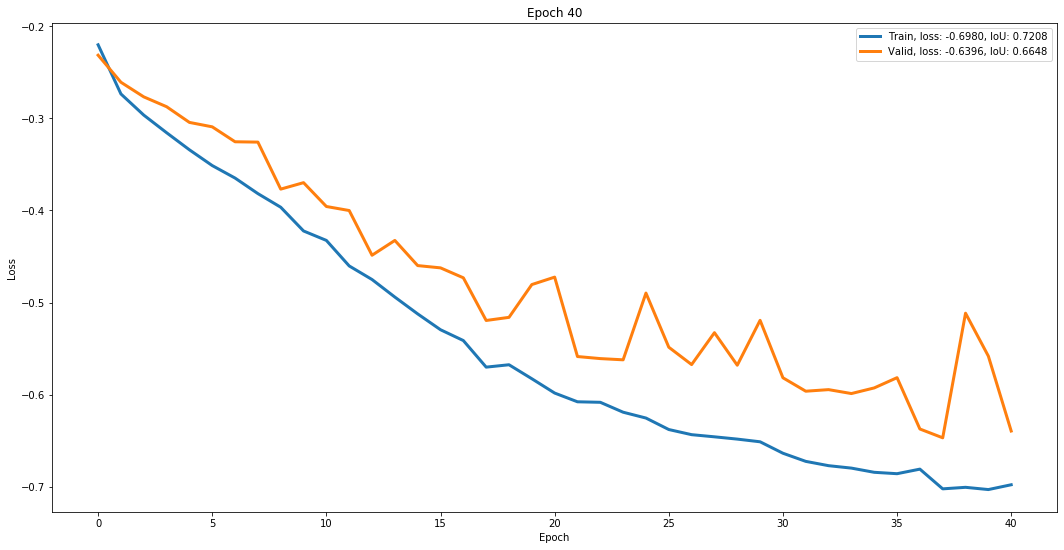

 Epoch: 41 of 100, Iter.: 44 of 44, Train Loss: -0.704825, IoU: 0.7247864
 Epoch: 41 of 100, Iter.: 44 of 44, Valid Loss: -0.653074, IoU: 0.658271


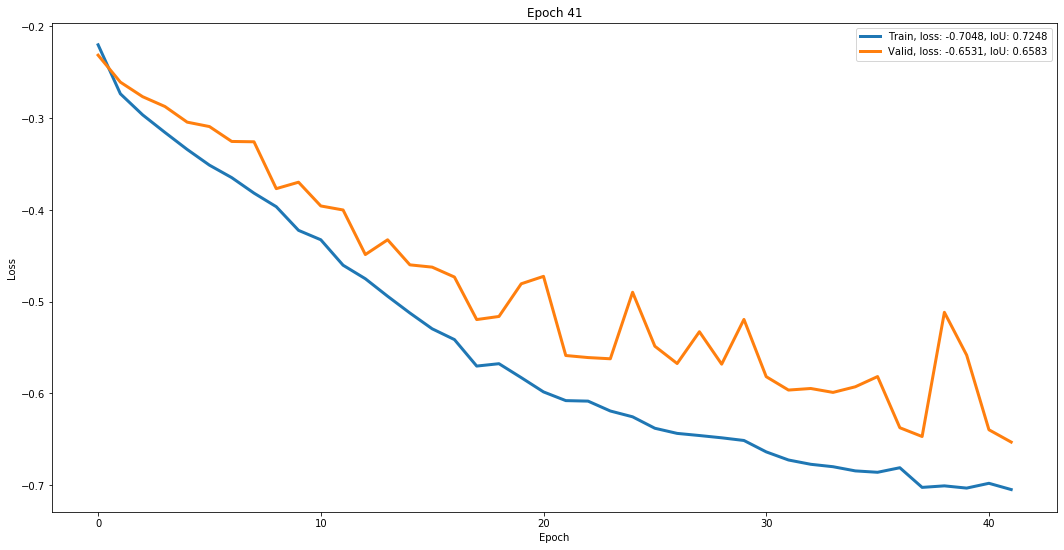

 Epoch: 42 of 100, Iter.: 44 of 44, Train Loss: -0.708267, IoU: 0.7249829
 Epoch: 42 of 100, Iter.: 44 of 44, Valid Loss: -0.638019, IoU: 0.660054


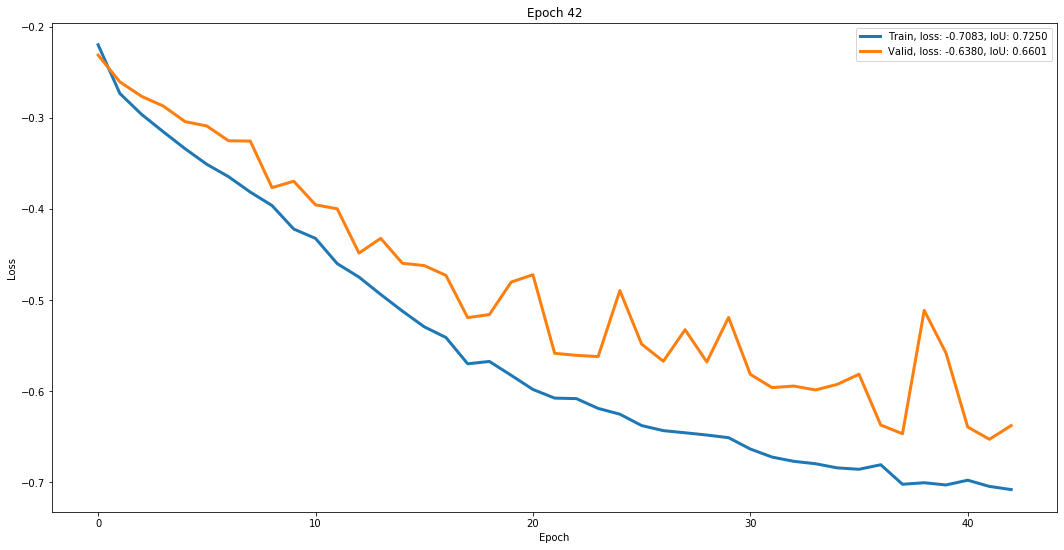

 Epoch: 43 of 100, Iter.: 44 of 44, Train Loss: -0.713346, IoU: 0.7298912
 Epoch: 43 of 100, Iter.: 44 of 44, Valid Loss: -0.615822, IoU: 0.645690


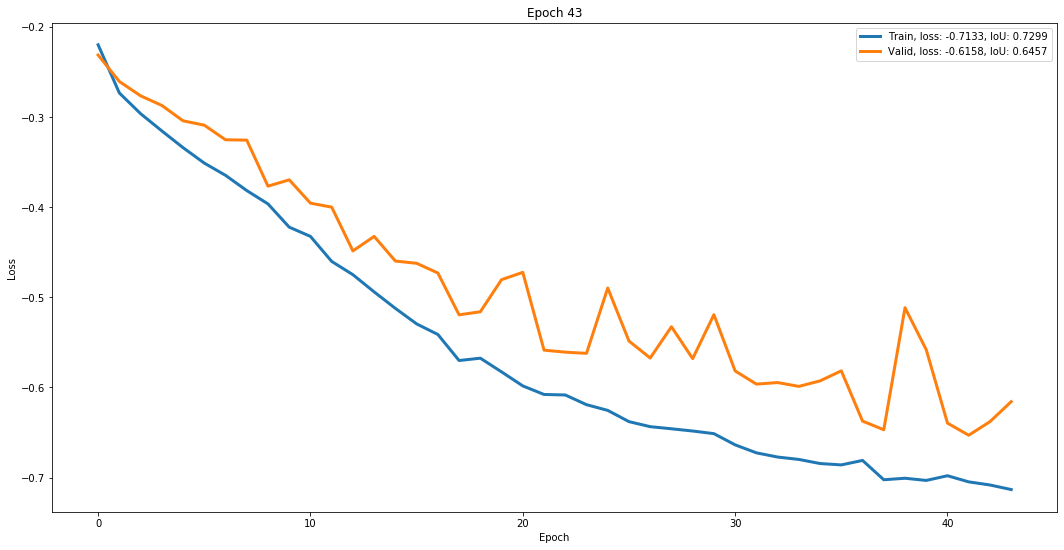

 Epoch: 44 of 100, Iter.: 44 of 44, Train Loss: -0.720052, IoU: 0.7373894
 Epoch: 44 of 100, Iter.: 44 of 44, Valid Loss: -0.576624, IoU: 0.611371


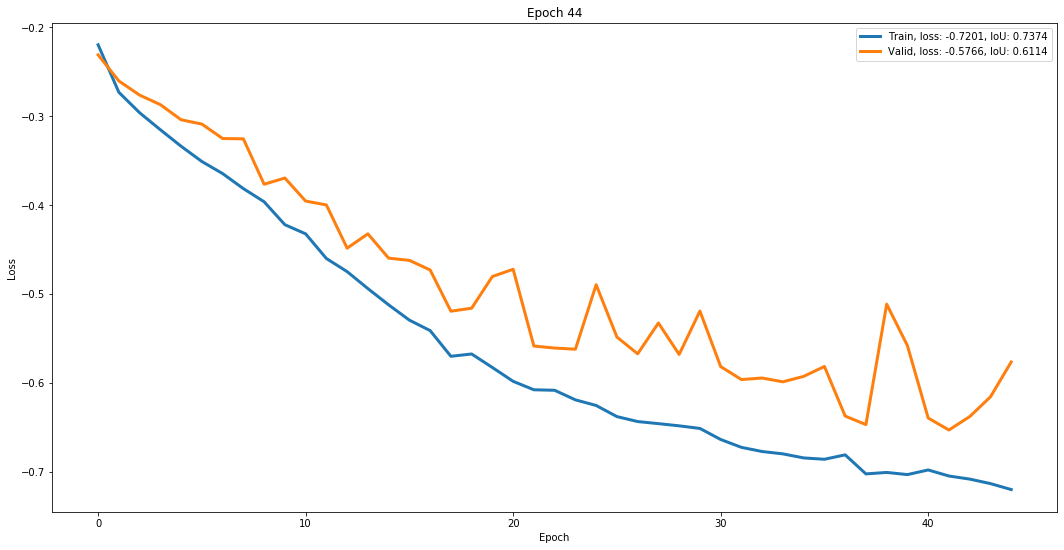

 Epoch: 45 of 100, Iter.: 44 of 44, Train Loss: -0.719146, IoU: 0.7371583
 Epoch: 45 of 100, Iter.: 44 of 44, Valid Loss: -0.633273, IoU: 0.658926


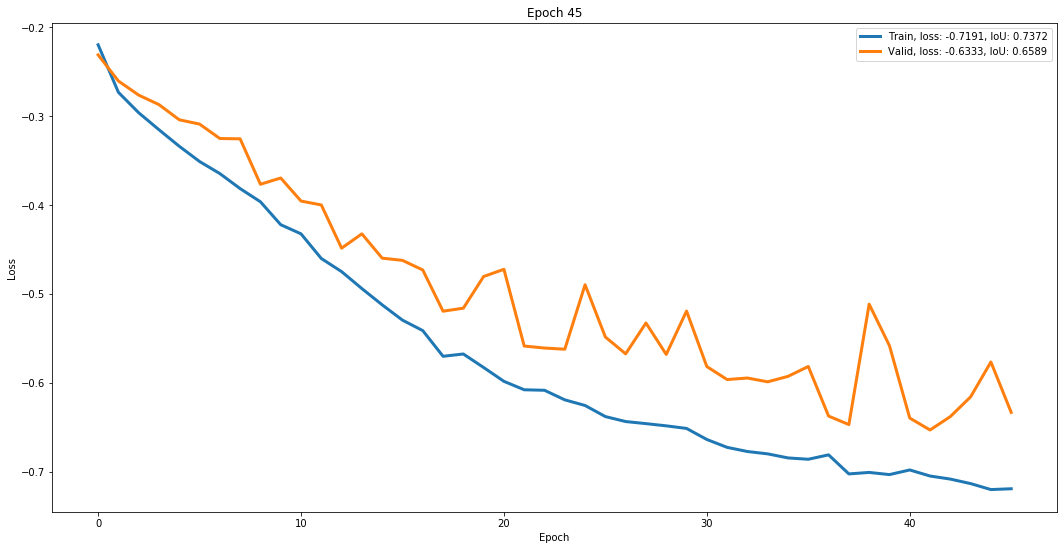

 Epoch: 46 of 100, Iter.: 44 of 44, Train Loss: -0.727058, IoU: 0.7410102
 Epoch: 46 of 100, Iter.: 44 of 44, Valid Loss: -0.610332, IoU: 0.626199


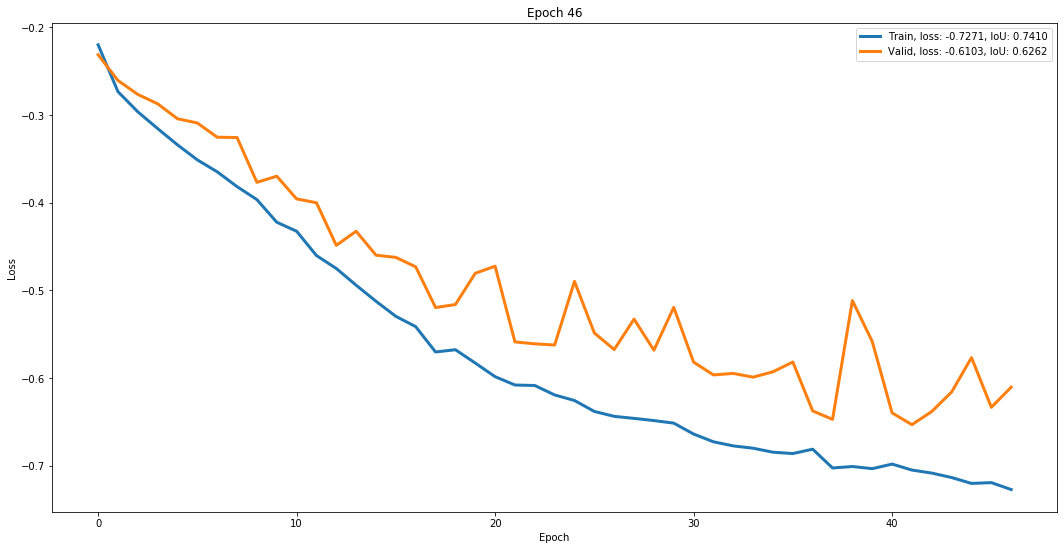

 Epoch: 47 of 100, Iter.: 44 of 44, Train Loss: -0.718581, IoU: 0.7351813
 Epoch: 47 of 100, Iter.: 44 of 44, Valid Loss: -0.650483, IoU: 0.676886


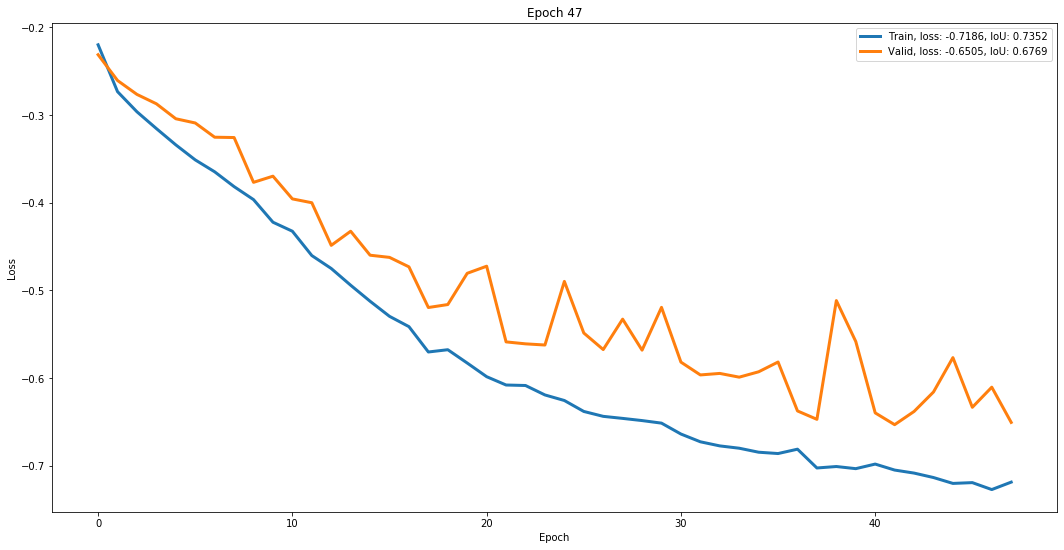

 Epoch: 48 of 100, Iter.: 44 of 44, Train Loss: -0.726846, IoU: 0.7431885
 Epoch: 48 of 100, Iter.: 44 of 44, Valid Loss: -0.638475, IoU: 0.656856


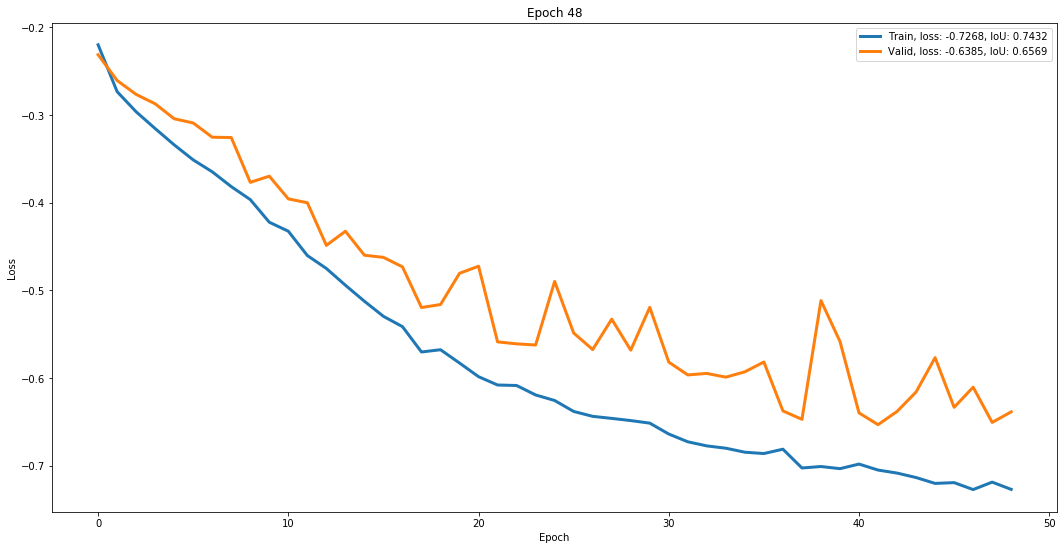

 Epoch: 49 of 100, Iter.: 44 of 44, Train Loss: -0.733257, IoU: 0.7426494
 Epoch: 49 of 100, Iter.: 44 of 44, Valid Loss: -0.636054, IoU: 0.659428


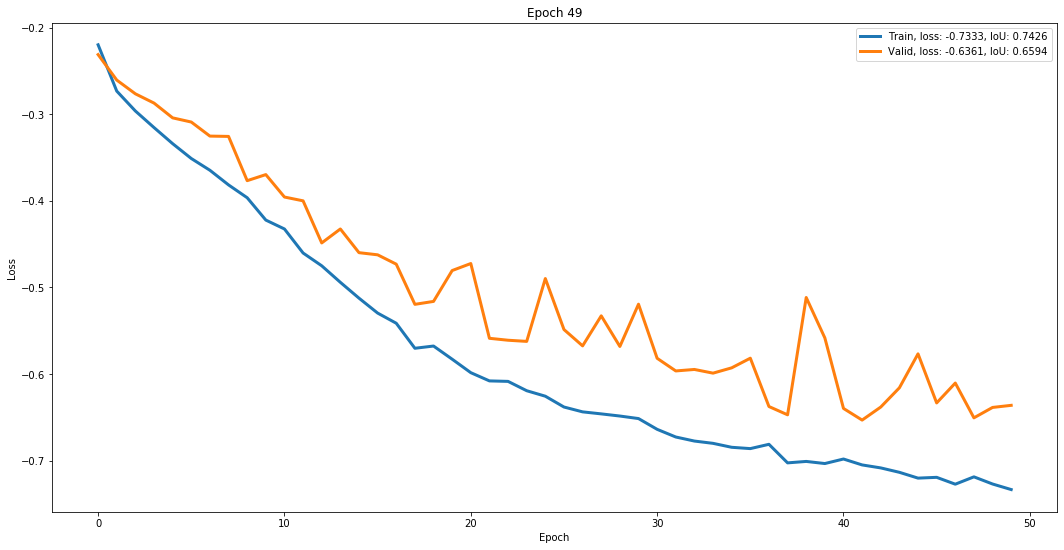

 Epoch: 50 of 100, Iter.: 44 of 44, Train Loss: -0.728024, IoU: 0.7461546
 Epoch: 50 of 100, Iter.: 44 of 44, Valid Loss: -0.636426, IoU: 0.661228


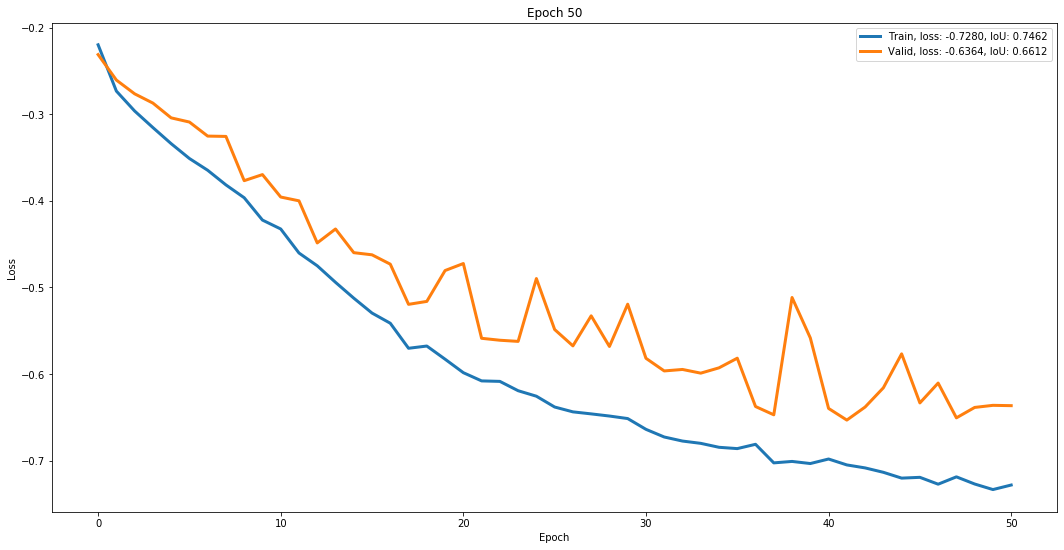

 Epoch: 51 of 100, Iter.: 44 of 44, Train Loss: -0.730104, IoU: 0.7476799
 Epoch: 51 of 100, Iter.: 44 of 44, Valid Loss: -0.652699, IoU: 0.676129


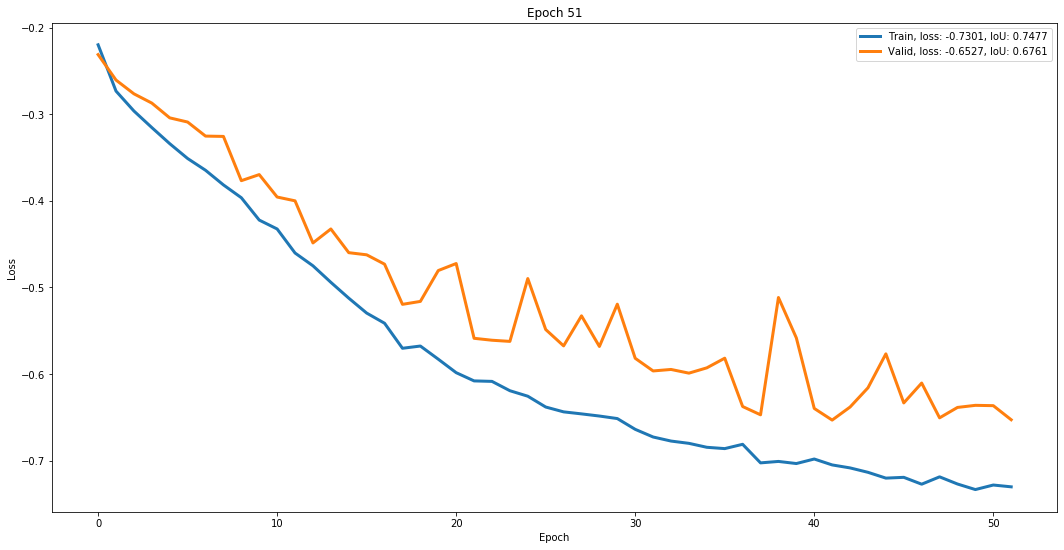

 Epoch: 52 of 100, Iter.: 44 of 44, Train Loss: -0.737896, IoU: 0.7481192
 Epoch: 52 of 100, Iter.: 44 of 44, Valid Loss: -0.652992, IoU: 0.681544


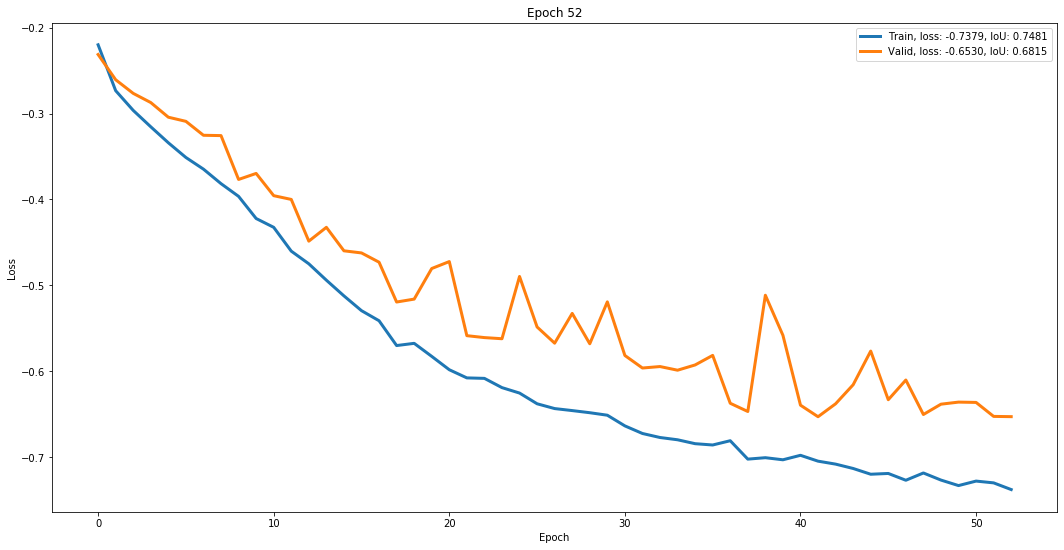

 Epoch: 53 of 100, Iter.: 44 of 44, Train Loss: -0.745175, IoU: 0.7556363
 Epoch: 53 of 100, Iter.: 44 of 44, Valid Loss: -0.666043, IoU: 0.682771


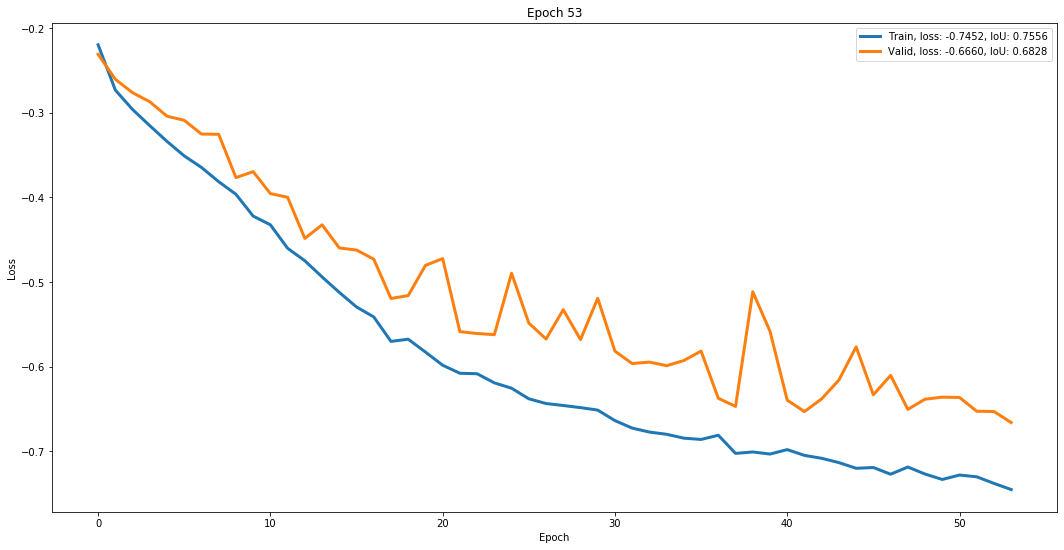

 Epoch: 54 of 100, Iter.: 44 of 44, Train Loss: -0.725575, IoU: 0.7430498
 Epoch: 54 of 100, Iter.: 44 of 44, Valid Loss: -0.673808, IoU: 0.703030


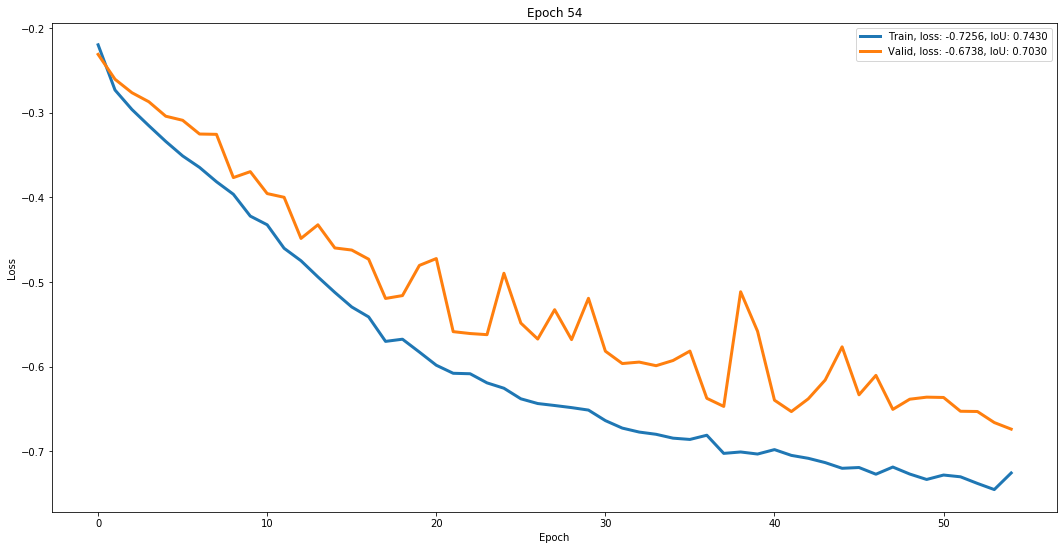

 Epoch: 55 of 100, Iter.: 44 of 44, Train Loss: -0.739910, IoU: 0.7565918
 Epoch: 55 of 100, Iter.: 44 of 44, Valid Loss: -0.671598, IoU: 0.699936


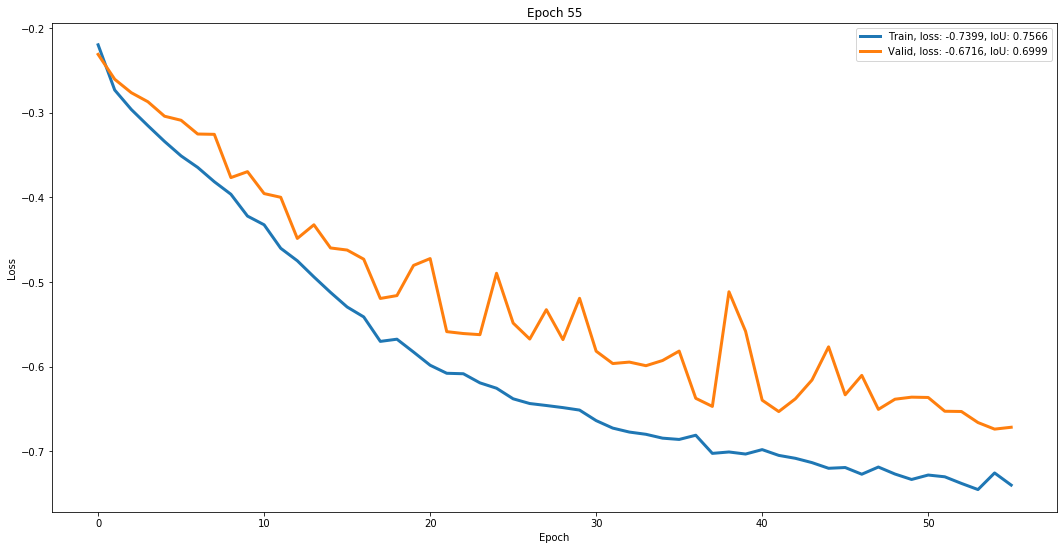

 Epoch: 56 of 100, Iter.: 44 of 44, Train Loss: -0.745178, IoU: 0.7561899
 Epoch: 56 of 100, Iter.: 44 of 44, Valid Loss: -0.575389, IoU: 0.600572


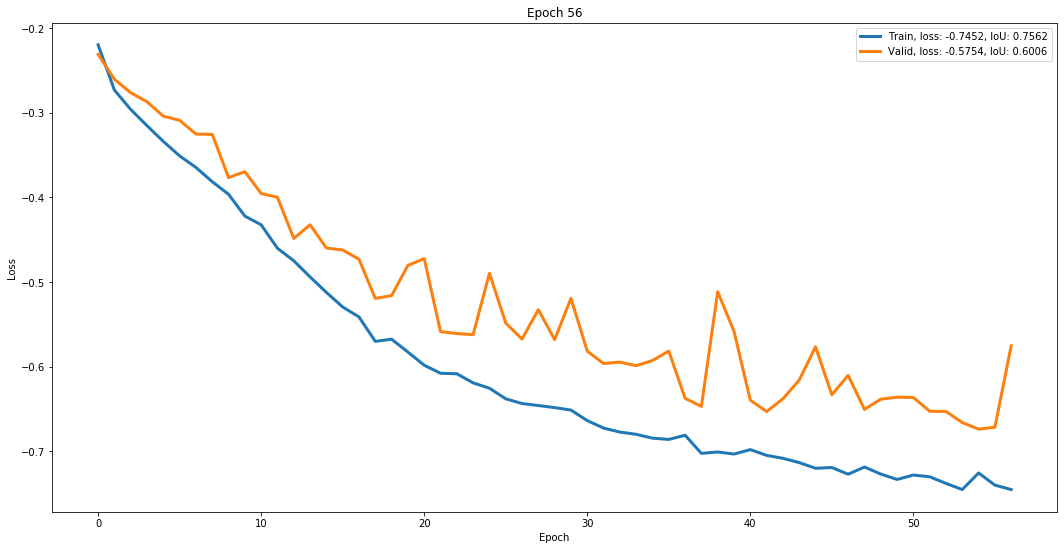

 Epoch: 57 of 100, Iter.: 44 of 44, Train Loss: -0.738769, IoU: 0.7535382
 Epoch: 57 of 100, Iter.: 44 of 44, Valid Loss: -0.614162, IoU: 0.637465


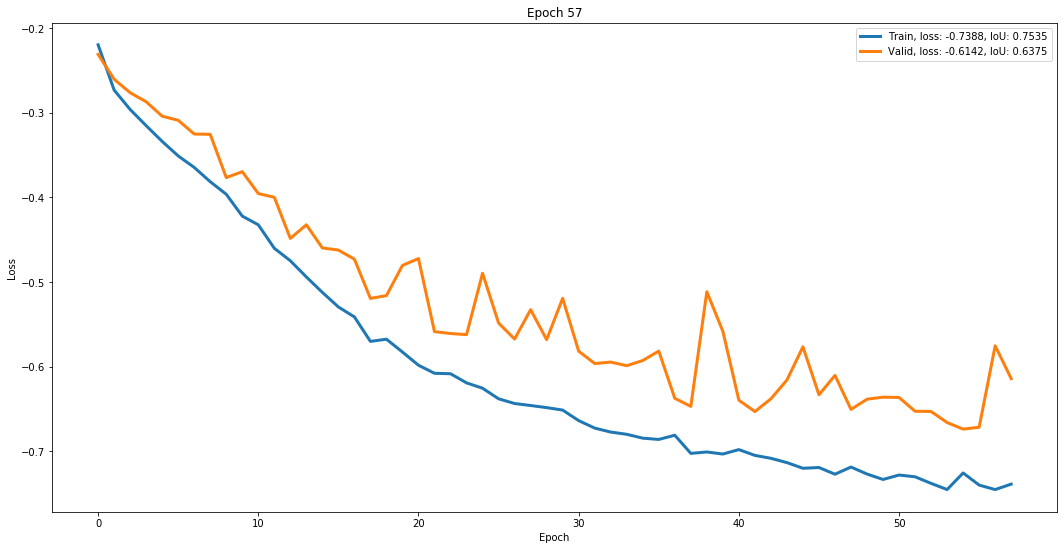

 Epoch: 58 of 100, Iter.: 44 of 44, Train Loss: -0.732820, IoU: 0.7493814
 Epoch: 58 of 100, Iter.: 44 of 44, Valid Loss: -0.654904, IoU: 0.676629


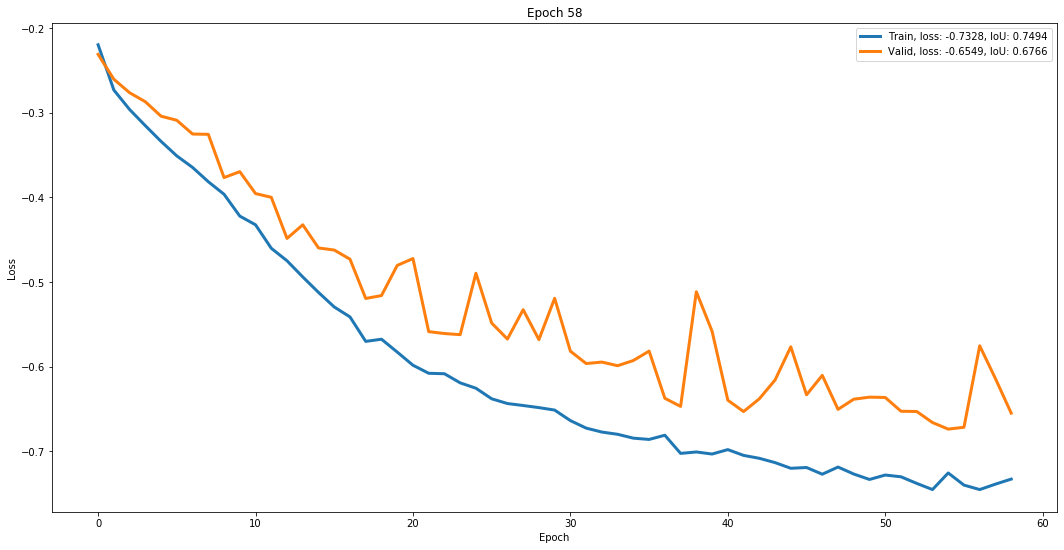

 Epoch: 59 of 100, Iter.: 44 of 44, Train Loss: -0.743155, IoU: 0.7573025
 Epoch: 59 of 100, Iter.: 44 of 44, Valid Loss: -0.664375, IoU: 0.690825


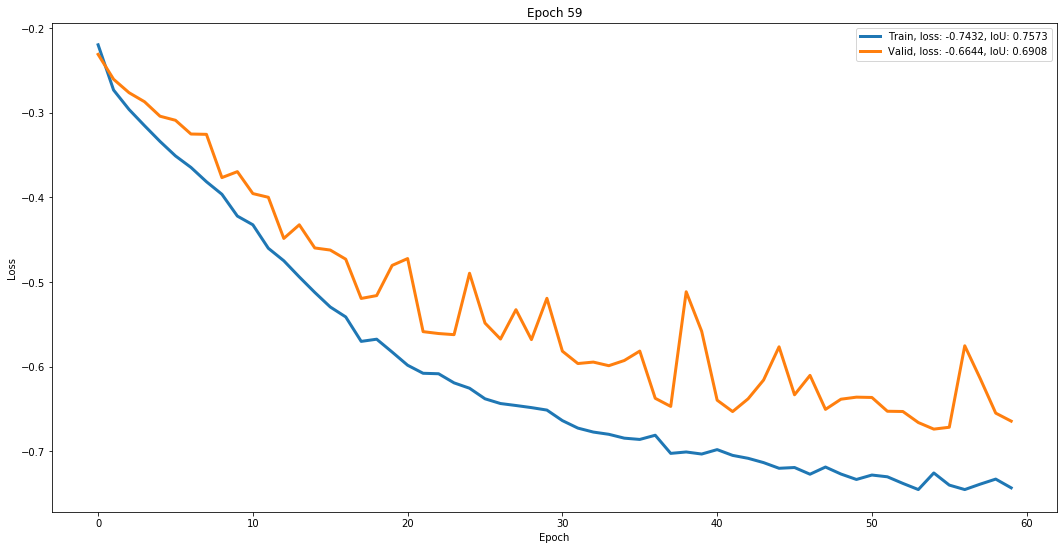

 Epoch: 60 of 100, Iter.: 44 of 44, Train Loss: -0.737172, IoU: 0.7500816
 Epoch: 60 of 100, Iter.: 44 of 44, Valid Loss: -0.554286, IoU: 0.582695


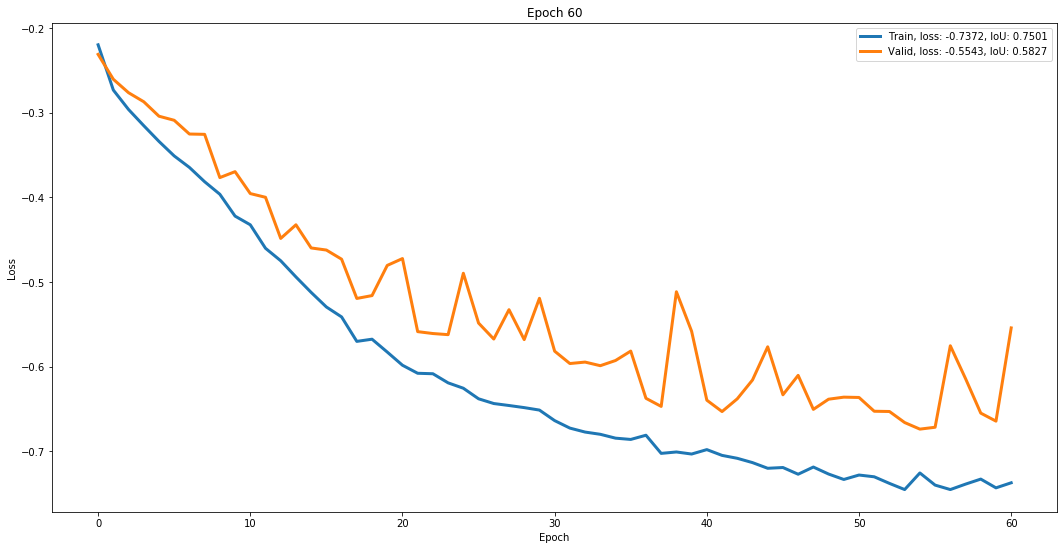

 Epoch: 61 of 100, Iter.: 44 of 44, Train Loss: -0.739572, IoU: 0.7529758
 Epoch: 61 of 100, Iter.: 44 of 44, Valid Loss: -0.560538, IoU: 0.599252


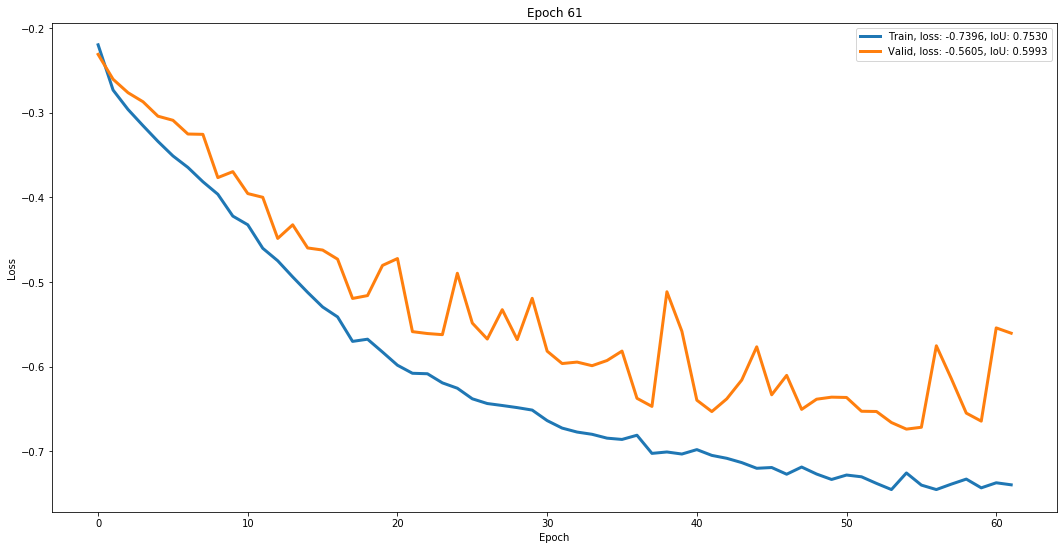

 Epoch: 62 of 100, Iter.: 44 of 44, Train Loss: -0.747605, IoU: 0.7611406
 Epoch: 62 of 100, Iter.: 44 of 44, Valid Loss: -0.610396, IoU: 0.653791


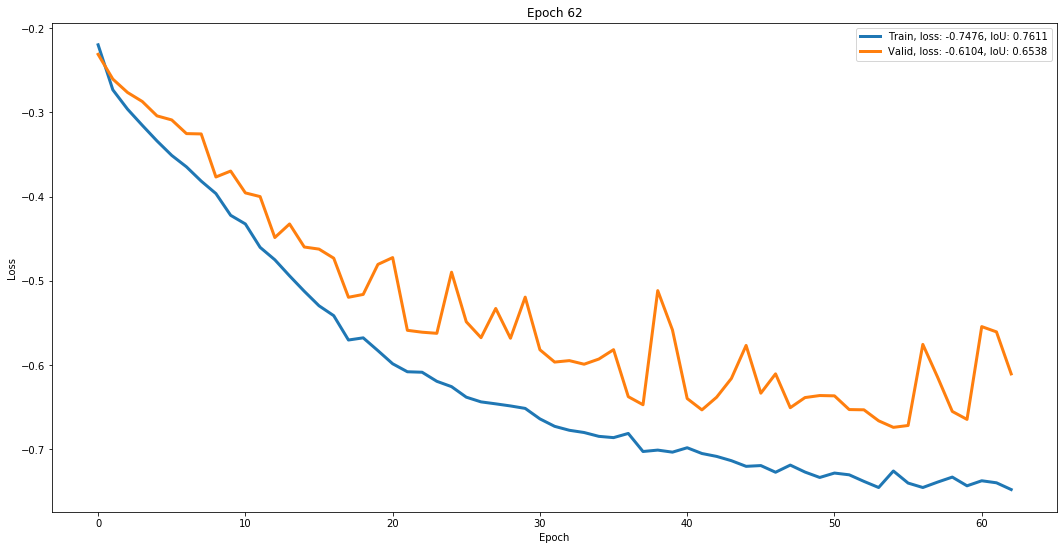

 Epoch: 63 of 100, Iter.: 44 of 44, Train Loss: -0.760890, IoU: 0.7655678
 Epoch: 63 of 100, Iter.: 44 of 44, Valid Loss: -0.665708, IoU: 0.680191


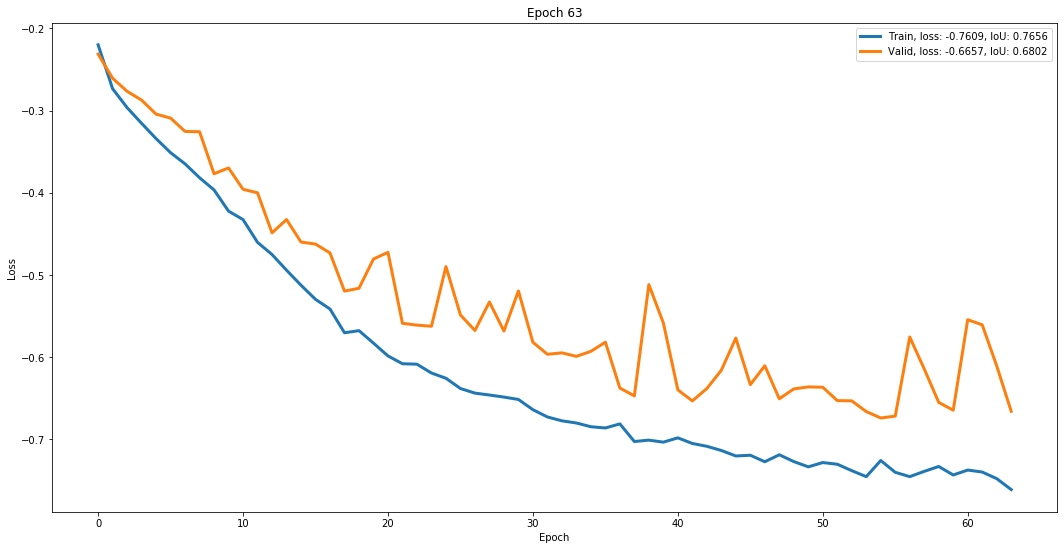

 Epoch: 64 of 100, Iter.: 44 of 44, Train Loss: -0.757061, IoU: 0.7651236
 Epoch: 64 of 100, Iter.: 44 of 44, Valid Loss: -0.662276, IoU: 0.682702


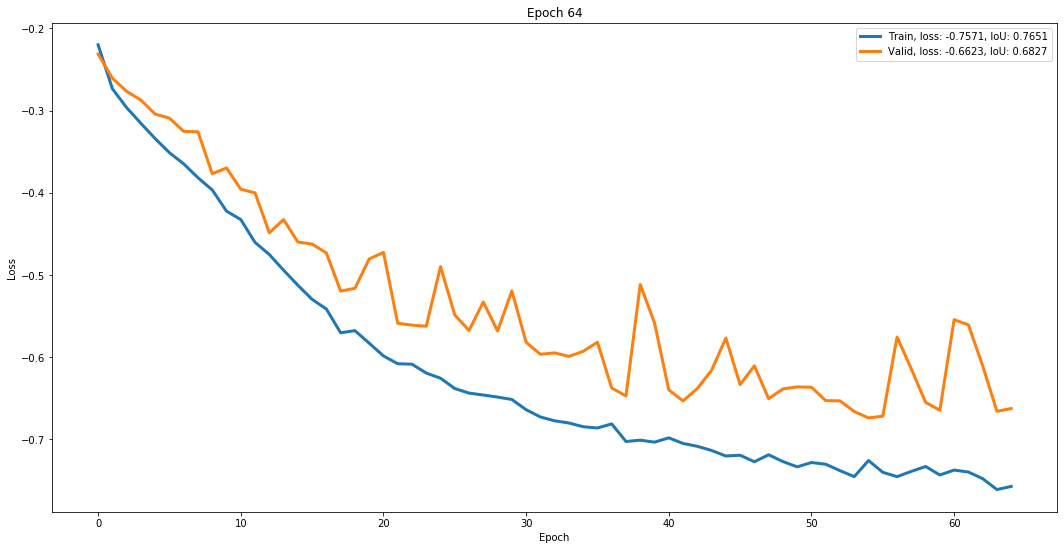

 Epoch: 65 of 100, Iter.: 44 of 44, Train Loss: -0.755863, IoU: 0.7646068
 Epoch: 65 of 100, Iter.: 44 of 44, Valid Loss: -0.648038, IoU: 0.659351


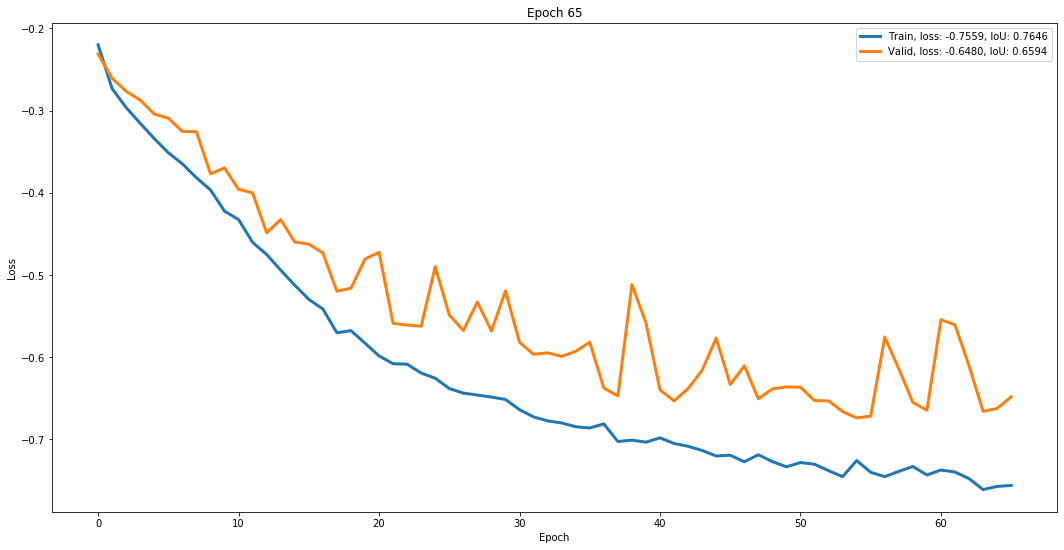


Early stopping. Target criteria has not improved for 10 epochs.

CPU times: user 16min 21s, sys: 11min 55s, total: 28min 17s
Wall time: 29min 30s


In [18]:
%%time

train_losses = []
val_losses = []
best_iou = 0
best_loss = np.Inf
best_epoch = -1
state = {}


for epoch in range(epochs):
    running_loss = 0
    running_iou = 0
    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimiser.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1)), end="")
        
        running_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_iou/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss = 0
    val_iou = 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)
    # compute overall epoch iou-s
    epoch_train_iou = running_iou/len(dataloader_train)
    epoch_val_iou = val_iou/len(dataloader_val)
    
    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou))
    
    
    # plot
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {epoch_train_loss:.4f}, IoU: {epoch_train_iou:.4f}', linewidth=3)
    plt.plot(np.arange(len(val_losses)), val_losses, label=f'Valid, loss: {epoch_val_loss:.4f}, IoU: {epoch_val_iou:.4f}', linewidth=3)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Epoch {epoch}')
    plt.legend(loc='best')
    plt.show()
    
    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch = epoch if best_iou == epoch_val_iou else best_epoch
    
    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['iou'] = best_iou
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'../checkpoints/ckpt_{model_name}.pth')
    
    elif best_epoch + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break
        
        
# load once more and write all the losses down (otherwise, will not have the losses for the last 10 epochs)
state = torch.load(f'../checkpoints/ckpt_{model_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'../checkpoints/ckpt_{model_name}.pth')

In [19]:
best_epoch, best_iou

(54, tensor(0.7030, device='cuda:0'))

## Evaluate validation performance (256*256 sized images)

In [20]:
%ls ../checkpoints

ckpt_UNet_BCELoss_baseline.pth     ckpt_UNet_IoULoss_baseline.pth
ckpt_UNet_IoUBCELoss_baseline.pth  ckpt_UNet_IoULoss_baseline_submitted.pth
ckpt_UNet_IoULoss_attention.pth    README.md
ckpt_UNet_IoULoss_augmented.pth


In [21]:
# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# load best weights and put into the evaluation mode
model.load_state_dict(torch.load(f'../checkpoints/ckpt_{model_name}.pth')['net'])

<All keys matched successfully>

In [22]:
print('Best epoch:', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['epoch'])
print(f'Validation IoU ({_size[0]}x{_size[0]}):', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['iou'].item())

Best epoch: 54
Validation IoU (256x256): 0.7030300498008728


## Pipeline

In [23]:
# def train(model, optim, criterion, dataloader, epoch, device):
#     pass

In [24]:
# def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
#     pass

In [25]:
# # Begin training
# model = UNet(channel_in=3, channel_out=1)
# model = model.to(DEVICE)

# train_losses = []
# test_losses = []
# best_iou = 0
# best_epoch = -1

# for epoch in notebook.tqdm(range(30)):
#     train_loss, train_iou = train(model, optimiser, criterion, dataloader_train, epoch, DEVICE)
#     train_losses.append(train_loss)
    
#     test_loss, test_iou = test(model, criterion, dataloader_val, epoch, DEVICE, best_iou, model_name='Unet_BCEWithLogitsLoss')
#     #scheduler.step(test_loss) # not always needed
#     test_losses.append(test_loss)
    
#     best_iou = max(best_iou, test_iou)
#     best_epoch = epoch if best_iou == test_iou else best_epoch

#     clear_output()
    
#     plt.figure(figsize=(18, 9))
#     plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, IoU: {train_iou}%')
#     plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, IoU: {test_iou}%')
#     plt.title(f'Epoch {epoch}')
#     plt.legend(loc='best')
#     plt.show()